In [2]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
import random
from scipy.stats import pearsonr, spearmanr, kendalltau
import pingouin as pg #compute repeated measure correlation

#save and load dictionaries/lists
import pickle

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [3]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, ZoneVariable, time_series_henColumn_tsRow, FB_daily, corr_from_dep2feature,FB_process,\
corr_from_feature2feature, correlationGraph, ZoneVariable, DataRepresentation1, sampen, chi2_distance, is_day, correct_key
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [4]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
id_run = config.id_run
dico_pen_tr = config.dico_pen_tr
dico_HAID_date = config.dico_HAID_date
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
date_consistent_barn_schedule = config.date_consistent_barn_schedule
path_extracted_data_chapter2 = os.path.join(path_extracted_data,'chapter2')
#create a director if not existing
if not os.path.exists(path_extracted_data_chapter2):
    os.makedirs(path_extracted_data_chapter2)

change the configuration file if not done yet!


# Download variables

In [4]:
#weather conditions
path_weather = os.path.join(r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather_exp1','Weather_process.csv')
df_weather_h = pd.read_csv(path_weather, sep=';', parse_dates=['date','Timestamp'])
df_weather_h = df_weather_h.sort_values('Timestamp') 
df_weather_h = df_weather_h.drop(['date'], axis=1)
df_weather_h['Timestamp_weather'] = df_weather_h['Timestamp'].copy()
print(df_weather_h.shape)
display(df_weather_h.head(3))

(7293, 13)


,Timestamp,temperature,humidity,wind speed,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather
0,2020-09-29 00:00:00,"10 °C\n(12:00 am CEST | Tuesday, September 29,...",average: 100% (100%)\n(12:00 am CEST | Tuesday...,"2 m/s\n(12:00 am CEST | Tuesday, September 29,...","rain\n(12:00 am CEST | Tuesday, September 29, ...","Moon Phase calculatorSeptember 29, 2020 0h",| waxing gibbous moon\n91.87% illuminated,0,10,2,100,rain,2020-09-29 00:00:00
1,2020-09-29 01:00:00,"10 °C\n(1:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(1:00 am CEST | Tuesday,...","3 m/s\n(1:00 am CEST | Tuesday, September 29, ...","rain\n(1:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 1h",| waxing gibbous moon\n92.09% illuminated,1,10,3,100,rain,2020-09-29 01:00:00
2,2020-09-29 02:00:00,"10 °C\n(2:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(2:00 am CEST | Tuesday,...","3 m/s\n(2:00 am CEST | Tuesday, September 29, ...","rain\n(2:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 2h",| waxing gibbous moon\n92.30% illuminated,2,10,3,100,rain,2020-09-29 02:00:00


In [5]:
#focal birds information (one row per focal bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';',
                    parse_dates=['InitialStartDate'], dayfirst=True)
print(df_FB.shape)
df_FB.head(3)

(232, 14)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,9,EPI,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,5,EPI,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


In [6]:
#info on selection process: 
#when possible (i.e. enough MEXP in each pens), 25% (resp.25%) of focal bird were selected randomly among the MEXP (resp. LEXP) 
#remaining 50% of focal animals were selected as a representative sample of the population (called here EPI, as part of a larger study
#with epigenetics analysis)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12), dt.datetime(2020,9,29)])].shape)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].shape)
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','R-Pen','CLASS'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(160, 14)
(150, 14)
(12, 4)


,Treatment,R-Pen,CLASS,HenID
0,OFH,1.0,EPI,20
1,OFH,1.0,LEXP,9
2,OFH,1.0,MEXP,10
3,OFH,3.0,EPI,20
4,OFH,3.0,LEXP,8
5,OFH,3.0,MEXP,9
6,TRAN,2.0,EPI,21
7,TRAN,2.0,LEXP,10
8,TRAN,2.0,MEXP,6
9,TRAN,4.0,EPI,19


In [7]:
#KBF&severity
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'df_all_HA.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
df_HA['FeatherDamage'] = df_HA['Feathers'].map(lambda x: 100-x)
df_HA['date_HA'] = df_HA['date'].copy()
print(df_HA.shape)
#display(df_HA.groupby(['HAID'])['date'].agg(lambda x: set(x)).reset_index())
display(df_HA['HAID'].value_counts())
#info on date
display(df_HA.groupby(['HAID','date','WOA','DOA'])['HenID'].count().reset_index())
print(df_HA.shape)
df_HA.head(3)

(846, 60)


HA1    176
HA3    176
HA4    176
HA2    160
HA5    158
Name: HAID, dtype: int64

,HAID,date,WOA,DOA,HenID
0,HA1,2020-11-23,25.0,173.0,175
1,HA2,2021-01-04,31.0,215.0,160
2,HA3,2021-02-01,35.0,243.0,176
3,HA4,2021-04-12,45.0,313.0,176
4,HA5,2021-07-25,60.0,417.0,157


(846, 60)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,backpack,FeatherDamage,date_HA
0,M,09:30,pen9,42grey,normal,25.0,NaN,0.0,0.0,0.0,...,109.0,0,0.0,42grey9sb,NaN,NaN,"['', '42', 'grey', '9', 'sb']",sb,NaN,2020-11-23
1,Mark,14:54,pen9,66grey,normal,0.0,NaN,50.0,0.0,0.0,...,509.0,16,0.0,66grey9sp,NaN,NaN,"['', '66', 'grey', '9', 'sp']",sp,14.0,2021-02-01
2,Camille,10:30,pen5,2green,normal,130.0,NaN,25.0,0.0,0.0,...,428.0,4,0.0,2green5pp,NaN,NaN,"['', '2', 'green', '5', 'pp']",pp,8.0,2021-02-01


#check animals with 0 fractures throught recorded life
df_ = df_HA.groupby(['HenID'])['severity'].agg(lambda x: list(x)).reset_index()
df_['NOKBF'] = df_['severity'].map(lambda x: sum(x)==0) #& len(x)>3
display(df_['NOKBF'].value_counts())
display(df_.head(3))
display(df_[df_['NOKBF']])
#check animals with 0 fractures at HA 5
df_ = df_HA[df_HA['HAID']=='HA5']
df_.sort_values('severity')[['HenID','HAID','severity','has_gap']].head(15)
#152/157*100 = 96.8

In [8]:
#info on selection process: repartition of Rearing pen in laying pen across class
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12), dt.datetime(2020,9,29)])].shape)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].shape)
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','R-Pen','CLASS',
                                                                                                 'PenID'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(160, 14)
(150, 14)
(47, 5)


,Treatment,R-Pen,CLASS,PenID,HenID
0,OFH,1.0,EPI,3,5
1,OFH,1.0,EPI,5,5
2,OFH,1.0,EPI,9,5
3,OFH,1.0,EPI,11,5
4,OFH,1.0,LEXP,3,2
5,OFH,1.0,LEXP,5,3
6,OFH,1.0,LEXP,9,2
7,OFH,1.0,LEXP,11,2
8,OFH,1.0,MEXP,3,3
9,OFH,1.0,MEXP,5,2


In [9]:
#info on selection process: repartition of class in laying pen
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','PenID','CLASS'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(24, 4)


,Treatment,PenID,CLASS,HenID
0,OFH,3,EPI,10
1,OFH,3,LEXP,5
2,OFH,3,MEXP,5
3,OFH,5,EPI,10
4,OFH,5,LEXP,4
5,OFH,5,MEXP,5
6,OFH,9,EPI,10
7,OFH,9,LEXP,5
8,OFH,9,MEXP,5
9,OFH,11,EPI,10


In [10]:
#info on selection process: uniform representation of rearing pen identity (RPenID) in each LPenID
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['PenID','R-Pen'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(16, 3)


,PenID,R-Pen,HenID
0,3,1.0,10
1,3,3.0,10
2,4,2.0,9
3,4,4.0,9
4,5,1.0,10
5,5,3.0,9
6,8,2.0,9
7,8,4.0,8
8,9,1.0,10
9,9,3.0,10


In [11]:
#daily variables of the movements (one row per available hen per day)
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True)
print(df_daily.shape)
#removing HA days
df_daily = df_daily[~df_daily['level'].isin(list(config.dico_HAID_date.values()))]
print(df_daily.shape)
#removing days with closed WG (removing two vaccinations date)
df_daily = df_daily[~df_daily['level'].isin(list(config.close_dates))]
print(df_daily.shape)
#removing when we changed to summer time (in next cleing will be automatic)
df_daily = df_daily[df_daily['level']!=dt.datetime(2021,3,28)]
print(df_daily.shape)
df_daily['vaccination_day'] = df_daily['level'].map(lambda x: config.dico_vaccinationDate_type.get(x,'No vaccination'))
display(df_daily['vaccination_day'].value_counts())
display(df_daily['Treatment'].unique())
df_daily['time_wg_open_h'] = df_daily['time_wg_open_sec'].map(lambda x: x/60/60)
df_daily['age'] = df_daily['level'].map(lambda x: (x-config.birth_date).days)
df_daily['WentinWG'] = df_daily['perc_1_Zone_while_WG_open'].map(lambda x: int(x>0))
display(df_daily['WentinWG'].value_counts())
#li_mvt = ['duration_1_Zone_min','duration_2_Zone_min', 'duration_3_Zone_min', 'duration_4_Zone_min', 'duration_5_Zone_min','perc_1_Zone_while_WG_open',
#          'nbr_stays_2_Zone', 'nbr_stays_4_Zone','nbr_stays_3_Zone', 'nbr_stays_5_Zone','nbr_stays_1_Zone',
#          'in_WG_15mnAfterOpening', 'SleepingHeight','vertical_travel_distance','WentinWG','time_wg_open_h']
#df_daily = df_daily[['HenID','PenID','level','age', 'CLASS', 'DOA','WOA', 'DIB','WIB','Total_number_transition']+li_mvt]
#display(df_daily[df_daily.isna().any(axis=1)])
#df_daily = df_daily[df_daily['level']>date_consistent_barn_schedule] #only since consistent barn schedule
#after stable, after chapter 2
df_daily = df_daily[df_daily['level']>dt.datetime(2020,11,24)]#not the day after HA
dico_cl = {'EPI':'REXP','MEXP':'MEXP','LEXP':'LEXP','LEXPLOST':'REXP','MEXPLOST':'REXP','NewAfterEpi':'NewAfterEpi',
          'NewAfterEpiLOST':'REXP'}
df_daily['CLASS'] = df_daily['CLASS'].map(lambda x: dico_cl[x])
display(df_daily['CLASS'].value_counts())
if df_daily[df_daily.isna().any(axis=1)].shape[0]>0:
    print('ERROR: YOU HAVE SOME NAN TO TAKE CARE OF:')
    display(df_daily.isna().sum(axis=0).sort_values().tail(15))
    #display(df_daily[df_daily.isna().any(axis=1)].head(3))
    print(df_daily[df_daily.isna().any(axis=1)].shape)
print(df_daily.shape)
df_daily.head(3)

(38253, 86)
(38253, 86)
(37508, 86)
(37508, 86)


No vaccination    36737
IBMa5Nobilis        463
IB4/91Nobilis       155
Ecoli               153
Name: vaccination_day, dtype: int64

array(['TRAN', 'OFH'], dtype=object)

1    24446
0    13062
Name: WentinWG, dtype: int64

NewAfterEpi    9504
REXP           8412
MEXP           6904
LEXP           5436
Name: CLASS, dtype: int64

ERROR: YOU HAVE SOME NAN TO TAKE CARE OF:


food_related_behavior_rm4        0
mid_cum_Z4_sec                  12
time_midduratioZ4_h             12
FirstTimestamp_4_Zone           12
KBF_interp                      97
weight_interp                   97
mid_cum_Z4_h_Morning           115
mid_cum_Z4_sec_Morning         115
FirstTimestamp_3_Zone          141
FirstTimestamp_2_Zone          179
FirstTimestamp_5_Zone         1011
FeatherDamage_interp          6070
FirstTimestamp_1_Zone_sec     9488
FirstTimestamp_1_Zone         9488
R-Pen                        10081
dtype: int64

(20093, 90)
(30256, 90)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,weekday,vaccination_day,time_wg_open_h,age,WentinWG
53,hen_131,2020-11-25,54000.0,15.0,"[654.0, 24673.0, 15720.0, 3219.0, 9734.0]",29.0,6.0,18.0,46.0,1.0,...,411.216667,262.000000,53.650000,162.233333,False,wednesday,No vaccination,6.250000,175,1
54,hen_131,2020-11-26,54000.0,15.0,"[280.0, 27891.0, 20572.0, 1632.0, 3625.0]",38.0,3.0,7.0,52.0,1.0,...,464.850000,342.866667,27.200000,60.416667,False,thursday,No vaccination,6.500000,176,1
55,hen_131,2020-11-27,54000.0,15.0,"[1397.0, 23308.0, 15043.0, 3902.0, 10350.0]",28.0,7.0,19.0,43.0,3.0,...,388.466667,250.716667,65.033333,172.500000,False,friday,No vaccination,6.333333,177,1


In [12]:
min(df_daily['WOA'].tolist()), max(df_daily['WOA'].tolist())

(25, 60)

# Visual of 5 mvt metrics

Series([], Name: PenID, dtype: int64)

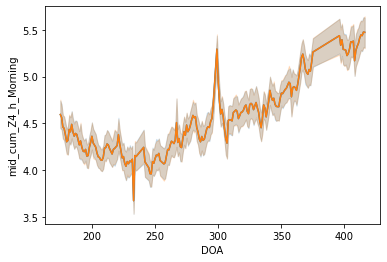

In [13]:
sns.lineplot(y='mid_cum_Z4_h_Morning', x='DOA', data=df_daily);
#pick: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. Because mini marker pen 3-5 did not worked on that day, maybe something else went wrong 
#that we did not detected, so I removed it
display(df_daily[df_daily['DOA']==219]['PenID'].value_counts())
df_daily = df_daily[df_daily['DOA']!=219]
sns.lineplot(y='mid_cum_Z4_h_Morning', x='DOA', data=df_daily);

Series([], Name: PenID, dtype: int64)

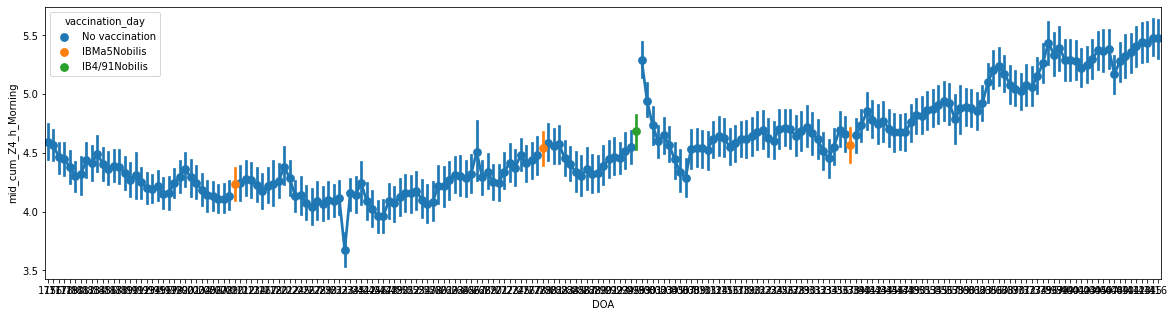

In [14]:
plt.figure(figsize=(20,5))
df_daily = df_daily[df_daily['DOA']!=219]
sns.pointplot(y='mid_cum_Z4_h_Morning', x='DOA', hue='vaccination_day', data=df_daily);
#pick: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. mini marker pen 3-5 did not worked so maybe something else too? should i remove it?
df_daily[df_daily['DOA']==219]['PenID'].value_counts()
#sns.scatterplot(y='mid_cum_Z4_h_Morning', x='DOA', color='red', data=df_daily[df_daily['vaccination_day']]);

Series([], Name: PenID, dtype: int64)

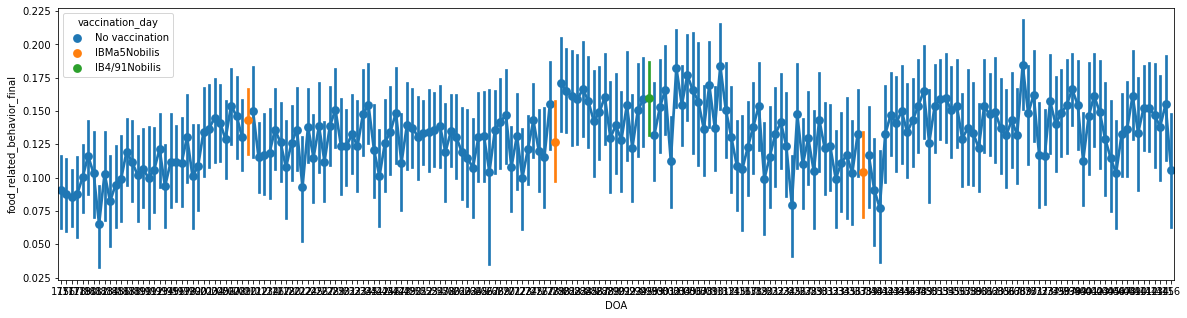

In [15]:
plt.figure(figsize=(20,5))
df_daily = df_daily[df_daily['DOA']!=219]
sns.pointplot(y='food_related_behavior_final', x='DOA', hue='vaccination_day', data=df_daily);
#pick: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. mini marker pen 3-5 did not worked so maybe something else too? should i remove it?
df_daily[df_daily['DOA']==219]['PenID'].value_counts()
#sns.scatterplot(y='mid_cum_Z4_h_Morning', x='DOA', color='red', data=df_daily[df_daily['vaccination_day']]);

Series([], Name: PenID, dtype: int64)

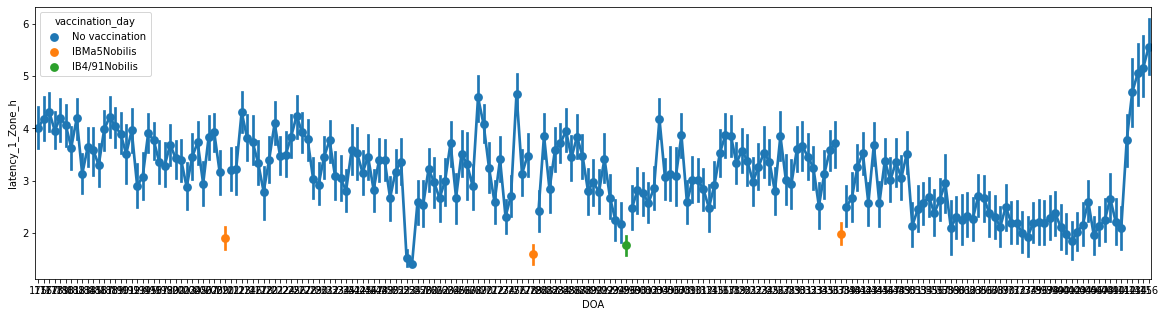

In [16]:
plt.figure(figsize=(20,5))
df_daily = df_daily[df_daily['DOA']!=219]
sns.pointplot(y='latency_1_Zone_h', x='DOA', hue='vaccination_day', data=df_daily);
#pick: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. mini marker pen 3-5 did not worked so maybe something else too? should i remove it?
df_daily[df_daily['DOA']==219]['PenID'].value_counts()
#sns.scatterplot(y='mid_cum_Z4_h_Morning', x='DOA', color='red', data=df_daily[df_daily['vaccination_day']]);

Series([], Name: PenID, dtype: int64)

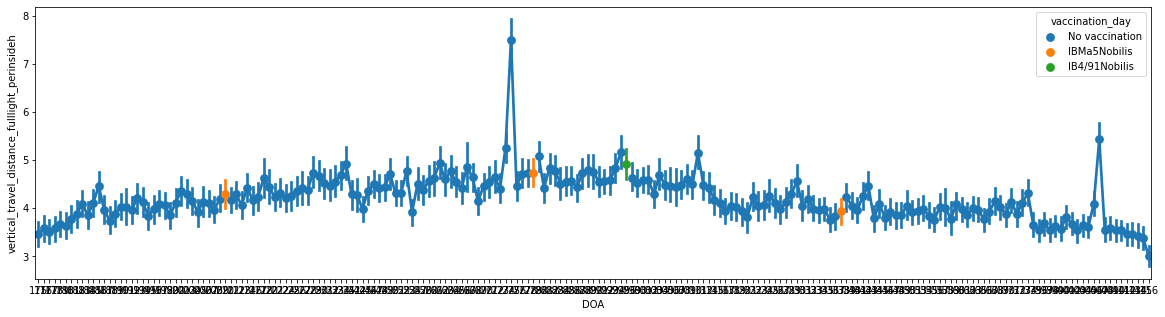

In [17]:
plt.figure(figsize=(20,5))
df_daily = df_daily[df_daily['DOA']!=219]
sns.pointplot(y='vertical_travel_distance_fulllight_perinsideh', x='DOA', hue='vaccination_day', data=df_daily);
#pick: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. mini marker pen 3-5 did not worked so maybe something else too? should i remove it?
df_daily[df_daily['DOA']==219]['PenID'].value_counts()
#sns.scatterplot(y='mid_cum_Z4_h_Morning', x='DOA', color='red', data=df_daily[df_daily['vaccination_day']]);

Series([], Name: PenID, dtype: int64)

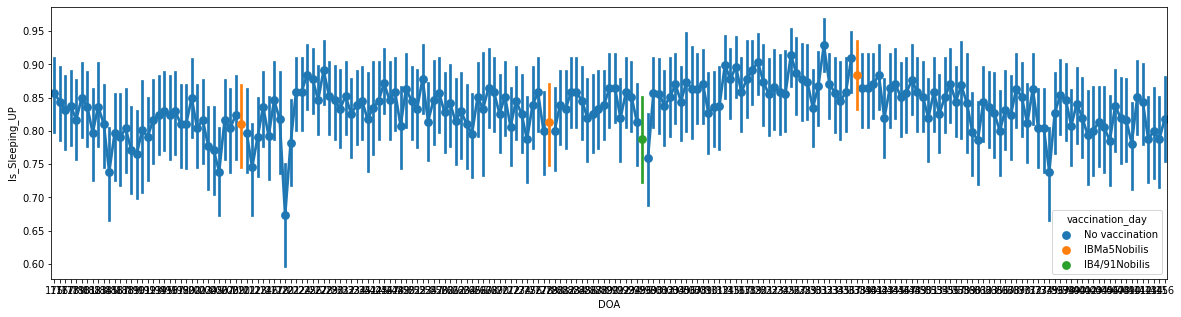

In [18]:
plt.figure(figsize=(20,5))
df_daily = df_daily[df_daily['DOA']!=219]
sns.pointplot(y='Is_Sleeping_UP', x='DOA', hue='vaccination_day', data=df_daily);
#pick: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. mini marker pen 3-5 did not worked so maybe something else too? should i remove it?
df_daily[df_daily['DOA']==219]['PenID'].value_counts()
#sns.scatterplot(y='mid_cum_Z4_h_Morning', x='DOA', color='red', data=df_daily[df_daily['vaccination_day']]);

In [19]:
#wg was closed on DOA 255, 256, dates dt.datetime(2021,2,13,0,0,0), dt.datetime(2021,2,14,0,0,0)
#df_daily[df_daily['DOA']==257][['DOA','temperature_C_avg','perc_duration_1_Zone','latency_1_Zone_h','PenID','HenID','level']]

# Add external temperature as environmental factor

In [20]:
#check variation over the day... exist very much
df_weather_h['date'] = df_weather_h['Timestamp'].map(lambda x: dt.datetime.date(x))
df_wday = df_weather_h[df_weather_h['hour'].isin([11,12,13,14,15,16])].groupby(['date'])['temperature_C'].agg(lambda x: list(x)).reset_index()
df_wday['temperature_C_avg'] = df_wday['temperature_C'].map(lambda x: np.mean(x))
display(df_wday.head(3))
#display(df_wday[df_wday['date']>=dt.date(2021,7,1)])

print(df_daily.shape)
df_daily['date'] = df_daily['level'].map(lambda x: dt.datetime.date(x))
df_daily = pd.merge(df_daily, df_wday, on='date', how='left')
print(df_daily.shape)
df_daily.head(2)

,date,temperature_C,temperature_C_avg
0,2020-09-29,"[11, 12, 12, 12, 12, 13]",12.0
1,2020-09-30,"[10, 11, 13, 13, 14, 14]",12.5
2,2020-10-01,"[13, 15, 15, 15, 15, 14]",14.5


(30256, 90)
(30256, 93)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,duration_5_Zone_min,Has_been_toptier_wholeday,weekday,vaccination_day,time_wg_open_h,age,WentinWG,date,temperature_C,temperature_C_avg
0,hen_131,2020-11-25,54000.0,15.0,"[654.0, 24673.0, 15720.0, 3219.0, 9734.0]",29.0,6.0,18.0,46.0,1.0,...,162.233333,False,wednesday,No vaccination,6.25,175,1,2020-11-25,"[0, 1, 2, 2, 2, 2]",1.500000
1,hen_131,2020-11-26,54000.0,15.0,"[280.0, 27891.0, 20572.0, 1632.0, 3625.0]",38.0,3.0,7.0,52.0,1.0,...,60.416667,False,thursday,No vaccination,6.50,176,1,2020-11-26,"[1, 3, 4, 4, 4, 3]",3.166667


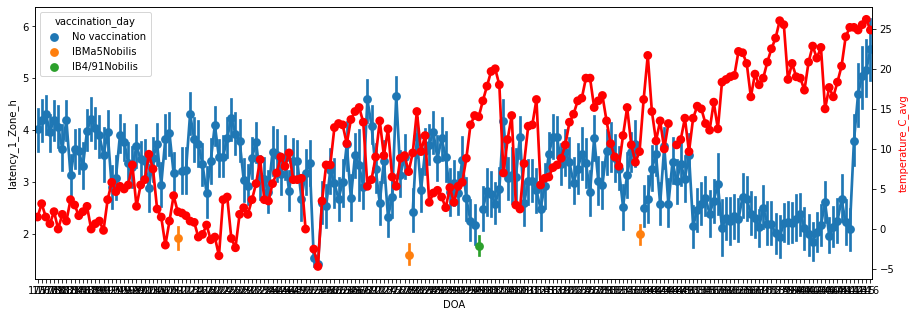

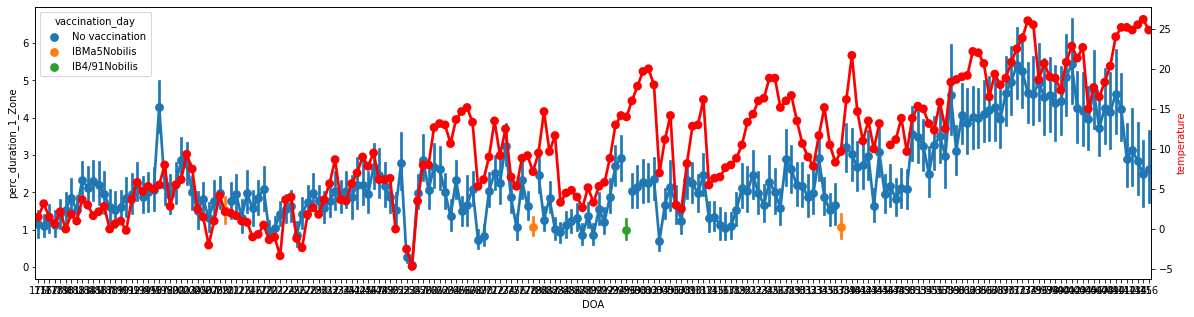

In [21]:
plt.figure(figsize=(15,5))
sns.pointplot(y='latency_1_Zone_h', x='DOA', hue='vaccination_day', size=0.3, alpha=0.4, data=df_daily);
ax2 = plt.twinx()
sns.pointplot(y='temperature_C_avg', x='DOA', color='red', size=0.3, alpha=0.4, data=df_daily, ax=ax2);
plt.ylabel("temperature_C_avg", color='red');
plt.show()

plt.figure(figsize=(20,5))
sns.pointplot(y='perc_duration_1_Zone', x='DOA', hue='vaccination_day', size=0.3, alpha=0.4, data=df_daily);
ax2 = plt.twinx()
sns.pointplot(y='temperature_C_avg', x='DOA', size=0.3,color='red', alpha=0.4, data=df_daily, ax=ax2);
plt.ylabel("temperature", color='red');

# Save weekly mvt for behavioural syndrome

In [22]:
df_daily[['HenID','level','latency_1_Zone_h','time_wg_open_h','perc_1_Zone_while_WG_open','duration_1_Zone_min']]

,HenID,level,latency_1_Zone_h,time_wg_open_h,perc_1_Zone_while_WG_open,duration_1_Zone_min
0,hen_131,2020-11-25,3.126111,6.250000,2.906667,10.900000
1,hen_131,2020-11-26,0.508889,6.500000,1.196581,4.666667
2,hen_131,2020-11-27,0.976389,6.333333,6.127193,23.283333
3,hen_131,2020-11-28,0.203889,6.000000,3.611111,13.000000
4,hen_131,2020-11-29,0.440833,6.500000,9.948718,38.800000
...,...,...,...,...,...,...
30251,hen_98,2021-07-20,0.916389,6.666667,27.870833,111.483333
30252,hen_98,2021-07-21,0.148333,8.500000,12.209150,62.266667
30253,hen_98,2021-07-22,1.283889,8.333333,26.423333,132.116667
30254,hen_98,2021-07-23,0.631111,8.333333,32.143333,160.716667


df_BT = df_daily.dropna(how='any', subset=['vertical_travel_distance','food_related_behavior','distribution_entropy',
                                          'latency_1_Zone_h','mid_cum_Z4_h_Morning','Is_Sleeping_UP',
                                          'food_related_behavior_rp', 'food_related_behavior_rm','duration_5_Zone_min'])
print(df_daily.shape, df_BT.shape)
df_BT = df_BT.groupby(['HenID','WOA','PenID','CLASS','Treatment']).agg(
           vertical_travel_distance_fulllight_perinsideh=pd.NamedAgg(column='vertical_travel_distance_fulllight_perinsideh', aggfunc=lambda x: int(np.nanmean(x))),
           weekly_vertical_travel_distance_dusk=pd.NamedAgg(column='vertical_travel_distance_dusk', aggfunc=lambda x: int(np.nanmean(x))),
           weekly_vertical_travel_distance_dusk_f=pd.NamedAgg(column='vertical_travel_distance_dusk', aggfunc=lambda x: np.nanmean(x)),
           weekly_sum_vertical_travel_distance_dusk=pd.NamedAgg(column='vertical_travel_distance_dusk', aggfunc=lambda x: np.sum(x)),
           #weekly_avertical_travel_distance=pd.NamedAgg(column='vertical_travel_distance', aggfunc=lambda x: sum(x)*7/len(x)),
           weekly_avg_food_related_behavior=pd.NamedAgg(column='food_related_behavior_final', aggfunc=lambda x: np.nanmean(x)),
           weekly_avg_distribution_entropy=pd.NamedAgg(column='distribution_entropy', aggfunc=lambda x: np.nanmean(x)),
           weekly_avg_latency_1_Zone_h=pd.NamedAgg(column='latency_1_Zone_h', aggfunc=lambda x: np.nanmean(x)),
           weekly_avg_perc_duration_5_Zone=pd.NamedAgg(column='perc_duration_5_Zone', aggfunc=lambda x: int(np.nanmean(x))),
           weekly_avg_latency_1_Zone_min=pd.NamedAgg(column='latency_1_Zone_h', aggfunc=lambda x: int(np.nanmean(x)*60)),
           weekly_nbr_Is_Sleeping_UP=pd.NamedAgg(column='Is_Sleeping_UP', aggfunc=lambda x: sum(x)),
           weekly_nbr_Is_Sleeping_NOTUP=pd.NamedAgg(column='Is_Sleeping_UP', aggfunc=lambda x: len(x)-sum(x)),
           weekly_has_Sleeping_NOTUP=pd.NamedAgg(column='Is_Sleeping_UP', aggfunc=lambda x: int((len(x)-sum(x))>0)),
           weekly_nbr_WentinWG=pd.NamedAgg(column='WentinWG', aggfunc=lambda x: sum(x)),
           weekly_nbr_NotWentinWG=pd.NamedAgg(column='WentinWG', aggfunc=lambda x: len(x)-sum(x)),
           weekly_has_NotWentinWG=pd.NamedAgg(column='WentinWG', aggfunc=lambda x: int((len(x)-sum(x))>0)),
           weekly_time_wg_open_h=pd.NamedAgg(column='time_wg_open_h', aggfunc=lambda x: [round(i,2) for i in x]),
           weekly_propr_timeWG=pd.NamedAgg(column='perc_1_Zone_while_WG_open', aggfunc=lambda x: int(np.nanmean(x))),
           weekly_propr_timeNOTWG=pd.NamedAgg(column='perc_1_Zone_while_WG_open', aggfunc=lambda x: 100-int(np.nanmean(x))),
           weekly_li_proprtimeWG=pd.NamedAgg(column='perc_1_Zone_while_WG_open', aggfunc=lambda x: list(x)),
           weekly_avg_mid_cum_Z4_h_Morning=pd.NamedAgg(column='mid_cum_Z4_h_Morning', aggfunc=lambda x: np.nanmean(x)),
           weekly_avg_time_midduratioZ4_min=pd.NamedAgg(column='mid_cum_Z4_h_Morning', aggfunc=lambda x: int(np.nanmean(x)*60)-120), #-2h as light start at 2h in the barn
           weekly_std_time_midduratioZ4_min=pd.NamedAgg(column='mid_cum_Z4_h_Morning', aggfunc=lambda x: int(np.std([i*60 for i in x]))),           
           #weekly_stdreg_time_midduratioZ4_min=pd.NamedAgg(column='mid_cum_Z4_h_Morning', aggfunc=lambda x: int(sum([(list(x)[i+1]*60-list(x)[i]*60)**2 if len(x)>0 else np.nan for i in range(0,len(x)-1)]))),  
           weekly_list_mid_cum_Z4_h_Morning=pd.NamedAgg(column='mid_cum_Z4_h_Morning', aggfunc=lambda x: [round(i,2) for i in x]),
           weekly_avg_temperature=pd.NamedAgg(column='temperature_C_avg', aggfunc=lambda x: np.nanmean(x)),
           weekly_min_date=pd.NamedAgg(column='level', aggfunc=lambda x: min(x)),
           weekly_nbr_available_Info=pd.NamedAgg(column='level', aggfunc=lambda x: len(x))).reset_index()
print(df_BT.shape)
plt.hist(df_BT['weekly_nbr_available_Info']);
plt.show()
display(df_BT[df_BT['weekly_nbr_available_Info']<6].head(3))
df_BT = df_BT[df_BT['weekly_nbr_available_Info']==7] #as variance
display(df_BT.shape)
display(df_BT.head(3))

#df_BT['weekly_avg_latency_1_Zone_h_max'] = df_BT['weekly_avg_latency_1_Zone_h'].copy()
#df_BT.loc[df_BT['weekly_avg_latency_1_Zone_h']>=6.5,'weekly_avg_latency_1_Zone_h_max'] = 6.5
df_BT['weekly_avg_latency_1_Zone_min_max'] = df_BT['weekly_avg_latency_1_Zone_min'].copy()
df_BT.loc[df_BT['weekly_avg_latency_1_Zone_min']>=int(6.5*60),'weekly_avg_latency_1_Zone_min_max'] = int(6.5*60)
df_BT['weekly_latency_1_Zone_propWG'] = df_BT['weekly_avg_latency_1_Zone_min_max'].map(lambda x: int(6.5*60)-x)
df_BT['weekly_latency_1_Zone_propNOTWG'] = df_BT['weekly_avg_latency_1_Zone_min_max'].map(lambda x: x)

df_BT['weekly_avg_perc_duration_NOT5_Zone'] = df_BT['weekly_avg_perc_duration_5_Zone'].map(lambda x: 100-x)
#df_BT['weekly_has_uncommon_behavior'] = df_BT['weekly_nbr_uncommon_behavior'].map(lambda x: int(x>0))
#display(df_BT['weekly_has_uncommon_behavior'].value_counts())
df_BT['PenID'] = df_BT['PenID'].map(lambda x: 'pen_'+str(int(x)))
df_BT.to_csv(os.path.join(path_extracted_data_chapter2,'df_weekly_BT.csv'), index=False, sep=',')

#try removing outlier
df_ = df_BT.groupby(['HenID'])['weekly_nbr_WentinWG'].agg(lambda x: list(x)).reset_index()
df_['perc_days_notinWG'] = df_['weekly_nbr_WentinWG'].map(lambda x: sum([i==0 for i in x])/len(x))
plt.hist(df_['perc_days_notinWG'], bins=30);
li_hen = df_[df_['perc_days_notinWG']>=0.75]['HenID'].tolist()
li_hen
plt.hist(df_BT[~df_BT['HenID'].isin(li_hen)]['weekly_avg_latency_1_Zone_min']);

#try removing outlier
df_ = df_BT.groupby(['HenID'])['weekly_vertical_travel_distance_dusk'].agg(lambda x: list(x)).reset_index()
df_['perc_0'] = df_['weekly_vertical_travel_distance_dusk'].map(lambda x: sum([i==0 for i in x])/len(x))
plt.hist(df_['perc_0'], bins=30);
li_hen = df_[df_['perc_0']>=0.75]['HenID'].tolist()
print(len(li_hen))
print(li_hen)
plt.hist(df_BT[~df_BT['HenID'].isin(li_hen)]['weekly_vertical_travel_distance_dusk']);

len(set(df_BT['HenID'].tolist()))

#data we use
df_ = df_BT.groupby(['WOA'])['HenID'].agg(lambda x: len(list(set(x)))).reset_index()
plt.ylabel('number of animals considered')
sns.scatterplot(x='WOA', y='HenID', data=df_);

#nbr obs / chicken
#df_BT.groupby(['HenID'])['WOA'].count().reset_index().sort_values(['WOA'])
df_ = df_BT.groupby(['HenID'])['WOA'].agg(lambda x: len(list(set(x)))).reset_index()
plt.ylabel('number of WOA per animals')
sns.scatterplot(x='HenID', y='WOA', data=df_);

df_BT[df_BT['weekly_avg_food_related_behavior']<-0.5]

li_mvt_4visual = ['weekly_vertical_travel_distance_fulllight', 'weekly_vertical_travel_distance_dusk',
                  'weekly_avg_food_related_behavior','weekly_avg_latency_1_Zone_min',
                  'weekly_nbr_Is_Sleeping_NOTUP','weekly_avg_mid_cum_Z4_h_Morning','weekly_avg_distribution_entropy']

#compute repeated measure correlation
for i in range(0,len(li_mvt_4visual)):
    beh1 = li_mvt_4visual[i]
    sns.displot(df_BT, x=beh1, kde=False, hue='WOA');
    plt.show();
    
    plt.figure(figsize=(17,4))
    sns.boxplot(x="HenID", y=beh1, data=df_BT); #[df_BT['HenID'].isin(li_hen_selected)]
    plt.show()
    
    for beh2 in li_mvt_4visual[i+1:]:
        print('----------------------------------------------------------------------------')
        print(beh1, '   ', beh2)
        print('----------------------------------------------------------------------------')
        #due to non-normality of most behaviors, we will in addition to repeated correaliton,
        #use the spearman rank and kendalltau correlations as well, but due to repeated measurement, we will do it for each WOA
        #for haID, df_BT_ in df_BT.groupby(['WOA']):
            #print(' ')
            #print(haID, df_BT_.shape)
            #print(pearsonr(df_BT_[beh1].tolist(), df_BT_[beh2].tolist()))
            #print(spearmanr(df_BT_[beh1].tolist(), df_BT_[beh2].tolist()))
            #print(kendalltau(df_BT_[beh1].tolist(), df_BT_[beh2].tolist()))
        try:
            print(pg.rm_corr(data=df_BT, x=beh1, y=beh2, subject='HenID'))
            print(pg.plot_rm_corr(data=df_BT, x=beh1, y=beh2, subject='HenID'));
            #plt.savefig(os.path.join(path_extracted_data_chapter2,'ReapCorr_'+beh1+'_'+beh2+'.png'), bbox_inches='tight')
            plt.show();
        except Exception as e:
            print(e)

# define contexts

In [23]:
#df_wday[df_wday['temperature_C_avg']>25]

In [24]:
#df_wday[df_wday['temperature_C_avg']<0]

In [25]:
#hot > 25 in average over the usual wg opening hours (include 6h)
df_daily['BS_type_ishot'] = df_daily['temperature_C_avg'].map(lambda x: 'hot' if x>25 else '')
#is cold <0 in average over the usual wg opening hours (include 6h)
df_daily['BS_type_iscold'] = df_daily['temperature_C_avg'].map(lambda x: 'cold' if x<0 else '')
#vaccination is already done: vaccination_day
df_daily['BS_type_isvaccinationday'] = df_daily['vaccination_day'].map(lambda x: x.replace('No vaccination',''))
#wg disturbance
df_daily['BS_type_disturbance_wg'] = df_daily['nbr_h_WGopen'].map(lambda x: 'WGDisturb' if x<5 else '')
#early days with a lot of disturbances
df_daily['BS_type_beforeLP1'] = df_daily['level'].map(lambda x: 'beforeLP1' if x<dt.datetime(2020,11,19) else '')
#LP
df_daily['BS_type_LP2'] = df_daily['level'].map(lambda x: 'LP2' if ((x<=dt.datetime(2020,12,16))&(x>=dt.datetime(2020,11,19))) else '')
df_daily['BS_type_LP10'] = df_daily['level'].map(lambda x: 'LP10' if ((x<=dt.datetime(2021,7,28))&(x>=dt.datetime(2021,7,1))) else '')
df_daily['BS_type_ALL'] = df_daily.apply(lambda x: x['BS_type_ishot']+'_'+x['BS_type_iscold']+'_'+x['BS_type_LP2']+'_'+\
                                         x['BS_type_LP10']+'_'+x['BS_type_isvaccinationday']+'_'+x['BS_type_disturbance_wg']+\
                                         '_'+x['BS_type_beforeLP1'], axis=1)
df_daily['BS_type_ALL'].value_counts()

______                          21370
__LP2____                        3217
___LP10___                       2525
_cold_____                       1243
hot___LP10___                     569
____IBMa5Nobilis_WGDisturb_       463
_cold____WGDisturb_               312
hot______                         306
____IB4/91Nobilis_WGDisturb_      155
_cold_LP2____                      96
Name: BS_type_ALL, dtype: int64

In [26]:
df_info = df_daily.groupby('BS_type_ALL')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
display(df_info)
li_cold = df_info[df_info['BS_type_ALL']=='_cold_____']['level'].iloc[0]

,BS_type_ALL,level,nbr_days
0,__LP2____,"[2020-11-25, 2020-11-26, 2020-11-27, 2020-11-2...",21
1,___LP10___,"[2021-07-04, 2021-07-05, 2021-07-06, 2021-07-0...",17
2,____IB4/91Nobilis_WGDisturb_,[2021-03-26],1
3,____IBMa5Nobilis_WGDisturb_,"[2020-12-30, 2021-03-09, 2021-05-07]",3
4,______,"[2020-12-17, 2020-12-18, 2020-12-19, 2020-12-2...",144
5,_cold_LP2____,[2020-12-11],1
6,_cold____WGDisturb_,"[2021-02-11, 2021-02-12]",2
7,_cold_____,"[2020-12-27, 2021-01-05, 2021-01-06, 2021-01-0...",8
8,hot___LP10___,"[2021-07-19, 2021-07-20, 2021-07-22, 2021-07-23]",4
9,hot______,"[2021-06-12, 2021-06-13]",2


# select within context days

In [27]:
dico_type_name = {'______':'time', '__LP2____':'LP2', '___LP10___':'LP10','____IBMa5Nobilis_WGDisturb_':'TypicalVaccinationDay',
                  '_cold_____':'cold'} #TODO: CHECK IF WE COULD GET HOT DAYS BACK ,'hot_____':'hot'
df_daily['BS_type'] = df_daily['BS_type_ALL'].map(lambda x: dico_type_name.get(x,'NotConsidered'))

In [28]:
#COLD context: among the group of consecutives days, we chose the coldest one
display(df_wday[df_wday['date'].isin(li_cold)])
li_notconsidered = [dt.datetime(2021,1,6), 
                    dt.datetime(2021,1,9), dt.datetime(2021,1,10), 
                    dt.datetime(2021,1,15), dt.datetime(2021,1,16)]
df_daily.loc[df_daily['level'].isin(li_notconsidered),'BS_type'] = 'NotConsidered'

,date,temperature_C,temperature_C_avg
89,2020-12-27,"[-3, -2, -2, -2, -1, -2]",-2.000000
98,2021-01-05,"[-1, -1, -1, -1, -1, -1]",-1.000000
99,2021-01-06,"[-1, -1, -1, -1, 0, 0]",-0.666667
102,2021-01-09,"[-3, -1, -1, -1, -1, -1]",-1.333333
103,2021-01-10,"[-1, -1, -1, -1, -1]",-1.000000
104,2021-01-11,"[-4, -4, -4, -3, -2, -3]",-3.333333
108,2021-01-15,"[-1, -1, -1, -1, -1, -2]",-1.166667
109,2021-01-16,"[-3, -3, -2, -2, -2, -2]",-2.333333


In [29]:
#LP2 context: among the LP2/LP10 days, we chose every sundays
df_daily.loc[(df_daily['weekday']!='sunday')&(df_daily['BS_type']=='LP2'),'BS_type'] = 'NotConsidered'
df_daily.loc[(df_daily['weekday']!='sunday')&(df_daily['BS_type']=='LP10'),'BS_type'] = 'NotConsidered'

In [30]:
#time: only sundays for now
df_daily.loc[(df_daily['weekday']!='sunday')&(df_daily['BS_type']=='time'),'BS_type'] = 'NotConsidered'

In [31]:
df_daily['BS_type'].value_counts()

NotConsidered            25258
time                      3167
cold                       463
TypicalVaccinationDay      463
LP2                        459
LP10                       446
Name: BS_type, dtype: int64

In [32]:
df_info = df_daily.groupby('BS_type')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
df_info

,BS_type,level,nbr_days
0,LP10,"[2021-07-04, 2021-07-11, 2021-07-18]",3
1,LP2,"[2020-11-29, 2020-12-06, 2020-12-13]",3
2,NotConsidered,"[2020-11-25, 2020-11-26, 2020-11-27, 2020-11-2...",170
3,TypicalVaccinationDay,"[2020-12-30, 2021-03-09, 2021-05-07]",3
4,cold,"[2020-12-27, 2021-01-05, 2021-01-11]",3
5,time,"[2020-12-20, 2021-01-03, 2021-01-17, 2021-01-2...",21


In [33]:
#not 2020-11-22 as we would loose quite some hens du to epi colelction on the 23 & we want the same number of observations, to have the same number of days between min and max obs. 
df_daily.loc[(df_daily['level']==dt.datetime(2020,11,22))&(df_daily['BS_type']=='LP2'),'BS_type'] = 'NotConsidered'

In [34]:
df_info = df_daily.groupby('BS_type')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
df_info['#days between max and min days considered'] = df_info['level'].map(lambda x: (max(x)-min(x)).days)
df_info['#days in between 2 consecutive obs'] = df_info['level'].map(lambda x: [(sorted(x)[i]-sorted(x)[i-1]).days for i in range(1,len(x))])
df_info['avg #days in between 2 consecutive obs'] = df_info['#days in between 2 consecutive obs'].map(lambda x: np.mean(x))
df_info

,BS_type,level,nbr_days,#days between max and min days considered,#days in between 2 consecutive obs,avg #days in between 2 consecutive obs
0,LP10,"[2021-07-04, 2021-07-11, 2021-07-18]",3,14,"[7, 7]",7.000000
1,LP2,"[2020-11-29, 2020-12-06, 2020-12-13]",3,14,"[7, 7]",7.000000
2,NotConsidered,"[2020-11-25, 2020-11-26, 2020-11-27, 2020-11-2...",170,241,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, ...",1.426036
3,TypicalVaccinationDay,"[2020-12-30, 2021-03-09, 2021-05-07]",3,128,"[69, 59]",64.000000
4,cold,"[2020-12-27, 2021-01-05, 2021-01-11]",3,15,"[9, 6]",7.500000
5,time,"[2020-12-20, 2021-01-03, 2021-01-17, 2021-01-2...",21,168,"[14, 14, 7, 7, 7, 14, 7, 7, 7, 7, 14, 7, 7, 7,...",8.400000


# select across context days

In [35]:
#across context: first day within each context to avoid haitaution when possible
li_levelacrosscontext = [dt.datetime(2021,7,18), dt.datetime(2020,11,29), dt.datetime(2021,3,9), dt.datetime(2020,12,27)]
df_daily['across_context'] = df_daily['level'].map(lambda x: int(x in li_levelacrosscontext))

In [36]:
df_info = df_daily.groupby('across_context')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
df_info['#days between max and min days considered'] = df_info['level'].map(lambda x: (max(x)-min(x)).days)
df_info['#days in between 2 consecutive obs'] = df_info['level'].map(lambda x: [(sorted(x)[i]-sorted(x)[i-1]).days for i in range(1,len(x))])
df_info['avg #days in between 2 consecutive obs'] = df_info['#days in between 2 consecutive obs'].map(lambda x: np.mean(x))
df_info

,across_context,level,nbr_days,#days between max and min days considered,#days in between 2 consecutive obs,avg #days in between 2 consecutive obs
0,0,"[2020-11-25, 2020-11-26, 2020-11-27, 2020-11-2...",199,241,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.217172
1,1,"[2020-11-29, 2020-12-27, 2021-03-09, 2021-07-18]",4,231,"[28, 72, 131]",77.000000


# visualise all observations

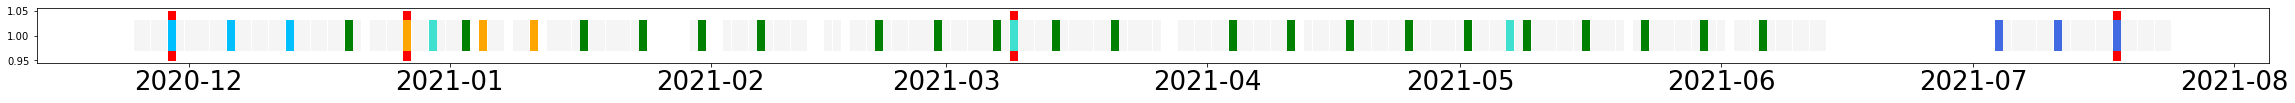

In [37]:
dico_c_color = {1:'red',
                0:'white',
                'LP10':'royalblue',
                'LP2':'deepskyblue',
                'time':'green',
                'TypicalVaccinationDay':'turquoise',
                'cold':'orange',
                'NotConsidered':'whitesmoke',
                'nomvtdata':'white'}
li_day = pd.date_range(start=df_daily['level'].min(), end=df_daily['level'].max(), freq = 'D')
dico_date_c = dict(zip(df_daily['level'].tolist(), df_daily['BS_type'].tolist()))
dico_date_ac = dict(zip(df_daily['level'].tolist(), df_daily['across_context'].tolist()))
dico_date_color = {}
for d in li_day:
    dico_date_color[d] = dico_c_color[dico_date_c.get(d,'nomvtdata')]
dico_date_colorac = {}
for d in li_day:
    dico_date_colorac[d] = dico_c_color[dico_date_ac.get(d,'nomvtdata')]
#plot
plt.figure(figsize=(40,1))
plt.scatter(dico_date_colorac.keys(), [1]*len(dico_date_colorac.keys()), color = list(dico_date_colorac.values()), 
            s=2500, marker='|',linewidths=8);
plt.scatter(dico_date_color.keys(), [1]*len(dico_date_color.keys()), color = list(dico_date_color.values()), 
            s=1000, marker='|',linewidths=8);
plt.xticks(fontsize=26)
plt.savefig(os.path.join(path_extracted_data_chapter2,'DaysSelected.png'), bbox_inches='tight')

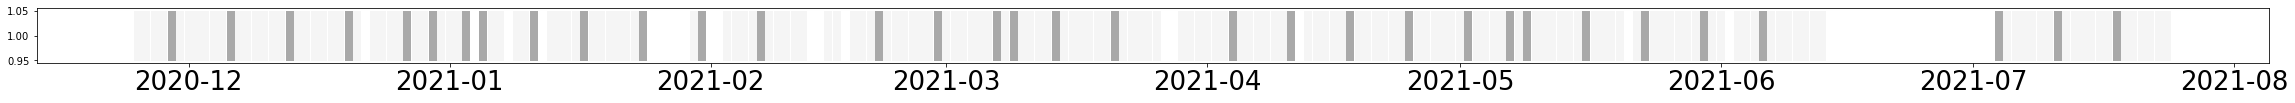

In [38]:
dico_c_color = {1:'darkgrey',
                0:'white',
                'LP10':'darkgrey',
                'LP2':'darkgrey',
                'time':'darkgrey',
                'TypicalVaccinationDay':'darkgrey',
                'cold':'darkgrey',
                'NotConsidered':'whitesmoke',
                'nomvtdata':'white'}
li_day = pd.date_range(start=df_daily['level'].min(), end=df_daily['level'].max(), freq = 'D')
dico_date_c = dict(zip(df_daily['level'].tolist(), df_daily['BS_type'].tolist()))
dico_date_ac = dict(zip(df_daily['level'].tolist(), df_daily['across_context'].tolist()))
dico_date_color = {}
for d in li_day:
    dico_date_color[d] = dico_c_color[dico_date_c.get(d,'nomvtdata')]
dico_date_colorac = {}
for d in li_day:
    dico_date_colorac[d] = dico_c_color[dico_date_ac.get(d,'nomvtdata')]
#plot
plt.figure(figsize=(40,1))
plt.scatter(dico_date_colorac.keys(), [1]*len(dico_date_colorac.keys()), color = list(dico_date_colorac.values()), 
            s=2500, marker='|',linewidths=8);
plt.scatter(dico_date_color.keys(), [1]*len(dico_date_color.keys()), color = list(dico_date_color.values()), 
            s=2500, marker='|',linewidths=8);
plt.xticks(fontsize=26)
plt.savefig(os.path.join(path_extracted_data_chapter2,'DaysSelected_B&W.png'), bbox_inches='tight')

In [39]:
#to add in PPWT
df_daily[df_daily['level'].isin([dt.datetime(2020,11,25),dt.datetime(2020,12,1),dt.datetime(2021,1,1),dt.datetime(2021,2,1),
                       dt.datetime(2021,3,1),dt.datetime(2021,4,1),dt.datetime(2021,4,1),dt.datetime(2021,5,1),
                                 dt.datetime(2021,6,1),dt.datetime(2021,7,24)])][['level','WIB','WOA']].drop_duplicates()

,level,WIB,WOA
0,2020-11-25,9,25
6,2020-12-01,9,26
36,2021-01-01,14,31
141,2021-03-01,22,39
170,2021-04-01,27,44
197,2021-05-01,31,48
255,2021-07-24,43,60
419,2021-06-01,35,52


In [40]:
print(df_daily['level'].min(), df_daily['level'].max())
print((df_daily['level'].max()-df_daily['level'].min()).days)
print((df_daily['level'].max()-df_daily['level'].min()).days/30)

2020-11-25 00:00:00 2021-07-24 00:00:00
241
8.033333333333333


# Save mvt for behavioural syndrome

In [41]:
display(df_daily['SleepingHeight'].value_counts(normalize=True))
df_daily['Sleeping_NotUppest'] = df_daily['SleepingHeight'].map(lambda x: int(x!=3))
display(df_daily['Sleeping_NotUppest'].value_counts(normalize=True))

3    0.691962
1    0.162877
2    0.142385
0    0.002776
Name: SleepingHeight, dtype: float64

0    0.691962
1    0.308038
Name: Sleeping_NotUppest, dtype: float64

In [42]:
dico_penid_penidfood = {'pen3':'FoodPenID1-4', 
                        'pen4':'FoodPenID1-4', 
                        'pen5':'FoodPenID5-8', 
                        'pen8':'FoodPenID5-8', 
                        'pen9':'FoodPenID9-12',
                        'pen10':'FoodPenID9-12', 
                        'pen11':'FoodPenID9-12', 
                        'pen12':'FoodPenID9-12', }
df_daily['FoodPenID'] = df_daily['PenID'].map(lambda x: dico_penid_penidfood[x])

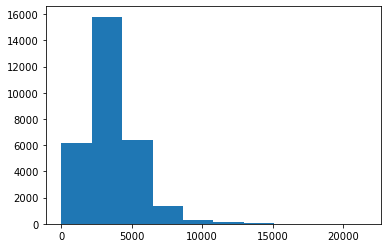

In [43]:
plt.hist(df_daily['duration_until8_inZ4']);

In [44]:
len(df_daily[df_daily['level']>dt.datetime(2021,7,1)]['HenID'].unique())

151

In [45]:
df_daily[(df_daily['BS_type']!='NotConsidered')&\
         (df_daily['nbr_visit_Z4_Morning_more60sec']<2)][['duration_until8_inZ4','nbr_visit_Z4_Morning_more60sec','mid_cum_Z4_h_Morning']]

,duration_until8_inZ4,nbr_visit_Z4_Morning_more60sec,mid_cum_Z4_h_Morning
11,1521,1,4.046389
31,2410,1,3.791389
84,3182,1,5.924167
108,4514,1,5.529444
133,3851,1,5.545833
...,...,...,...
30084,8303,1,6.846667
30097,7993,1,6.889722
30151,2774,1,2.683611
30200,4764,1,3.038889


In [46]:
3650/60/60

1.0138888888888888

In [47]:
df_daily[(df_daily['BS_type']!='NotConsidered')&\
         (df_daily['nbr_visit_Z4_Morning_more60sec']>=2)][['duration_until8_inZ4','nbr_visit_Z4_Morning_more60sec','mid_cum_Z4_h_Morning']]

,duration_until8_inZ4,nbr_visit_Z4_Morning_more60sec,mid_cum_Z4_h_Morning
4,3421,4,4.028333
18,2977,2,3.921667
25,1942,3,4.586944
34,2254,3,4.036111
38,3278,5,3.885556
...,...,...,...
30221,6908,3,4.283056
30227,4963,2,4.163333
30235,5153,2,5.481944
30242,4315,2,5.104167


In [48]:
#Z4: day after the VD and CET, like night: night that follow
li_Z4mvt = ['mid_cum_Z4_h_Morning','nbr_visit_Z4_Morning_more60sec','duration_until8_inZ4']
for mv in li_Z4mvt:
    #not efficient way, but easy
    df_daily[mv+'_dafter'] = df_daily.apply(lambda x: df_daily[(df_daily['HenID']==x['HenID'])&\
                                                               (df_daily['DIB']==x['DIB']+1)][mv].values, axis=1)
    df_daily[mv+'_dafter'] = df_daily[mv+'_dafter'].map(lambda x: x[0] if len(x)==1 else np.nan)
    display(df_daily[df_daily['BS_type'].isin(['cold','TypicalVaccinationDay'])][[mv+'_dafter',mv]].head(3))

,mid_cum_Z4_h_Morning_dafter,mid_cum_Z4_h_Morning
31,3.849722,3.791389
34,3.901389,4.036111
39,4.071667,3.975833


,nbr_visit_Z4_Morning_more60sec_dafter,nbr_visit_Z4_Morning_more60sec
31,1.0,1
34,1.0,3
39,5.0,2


,duration_until8_inZ4_dafter,duration_until8_inZ4
31,2127.0,2410
34,2424.0,2254
39,2852.0,2498


In [49]:
#replace the value to avoid having two columns depending ont he context etc. would be annoying for the across contex too
for mv in li_Z4mvt:
    df_daily[mv] = np.where(df_daily['BS_type'].isin(['cold','TypicalVaccinationDay']), 
                                df_daily[mv+'_dafter'], #when condtion is trux
                                df_daily[mv])
    display(df_daily[df_daily['BS_type'].isin(['cold','TypicalVaccinationDay'])][[mv+'_dafter',mv]].head(3))

,mid_cum_Z4_h_Morning_dafter,mid_cum_Z4_h_Morning
31,3.849722,3.849722
34,3.901389,3.901389
39,4.071667,4.071667


,nbr_visit_Z4_Morning_more60sec_dafter,nbr_visit_Z4_Morning_more60sec
31,1.0,1.0
34,1.0,1.0
39,5.0,5.0


,duration_until8_inZ4_dafter,duration_until8_inZ4
31,2127.0,2127.0
34,2424.0,2424.0
39,2852.0,2852.0


In [50]:
print(list(df_daily.columns))

['HenID', 'level', 'verification_daily_total_duration', 'verification_daily_total_nbr_hour', 'dur_values', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone', 'perc_duration_2_Zone', 'perc_duration_1_Zone', 'time_wg_open_sec', 'duration_sincedaystarted_beforeWGopened_sec', 'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone', 'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen', 'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone', 'list_of_durations', 'food_related_behavior', 'food_related_behavior_rp', 'food_related_behavior_rm', 'food_related_behavior4', 'food_related_behavior_rp4', 'food_related_behavior_rm4', 'nestboxes_related_behavior', 'mid_cum_Z4_sec', 'Total_number_transition', 'nbr_stays', 'distribution_entropy', 'vertical_travel_distance', 'vertical_travel_distance_dawn', 'vertical_travel_distance_dusk', 'nbr_stays_total', 'nbr_stays_3_Zone', 'nbr_stays_4_Zone', 'nbr_stays_5_Zo

#list of hen that always outside during LP10
df_ = df_BS[df_BS['BS_type']=='LP10'].groupby('HenID')['WentinWG'].agg(lambda x: list(x)).reset_index()
df_['alwaysWG'] = df_['WentinWG'].map(lambda x: sum(x)==len(x))
df_['nbrObs'] = df_['WentinWG'].map(lambda x: len(x))
display(df_.head(3))
li_hen_WG = df_[(df_['alwaysWG'])&(df_['nbrObs']<3)]['HenID'].tolist()
print(len(li_hen_WG))
print(li_hen_WG)
li_hen_WG = df_[df_['alwaysWG']]['HenID'].tolist()
print(len(li_hen_WG))
print(li_hen_WG)

In [53]:
df_daily['food_reactivity_index'] = df_daily['food_related_behavior_final'].map(lambda x: x*-1)
df_daily['food_reactivity_index_forward'] = df_daily['food_related_behavior_rp_final'].map(lambda x: x*-1)
df_daily['food_reactivity_index_backward'] = df_daily['food_related_behavior_rm_final'].map(lambda x: x*-1)

In [55]:
#duration_until8_inZ4
li_henselected = list(df_daily[df_daily['level']>dt.datetime(2021,7,1)]['HenID'].unique())
#&(df_daily['HenID'].isin(li_henselected))
df_BS = df_daily[(df_daily['BS_type']!='NotConsidered')][['TrackingSystemID','level','DOA','DIB','FoodPenID','BS_type','Treatment','CLASS','PenID',
                                                        'temperature_C_avg','HenID_WIB','HenID','across_context',
                                                        'KBF_interp','weight_interp',
                                                        'WentinWG','mid_cum_Z4_h_Morning','Sleeping_NotUppest', 
                                                        'vertical_travel_distance_fulllight_perinsideh',
                                                        'food_reactivity_index', 'food_reactivity_index_backward',
                                                        'food_reactivity_index_forward']].copy()
#'latency_1_Zone_h','nbr_h_WGopen','perc_1_Zone_while_WG_open','FeatherDamage_interp','Has_been_toptier_wholeday'
#'nbr_visit_Z4_Morning_more60sec'
print(df_BS.shape)
df_BS = df_BS[~df_BS['mid_cum_Z4_h_Morning'].isnull()]
print(df_BS.shape)
#df_BS['nbr_visit_Z4_Morning_more60sec'] = df_BS['nbr_visit_Z4_Morning_more60sec'].map(lambda x: max(1,x))
#df_BS['nbr_visit_Z4_Morning_more60sec'] = df_BS['nbr_visit_Z4_Morning_more60sec'].map(lambda x: min(8,x))
print(df_BS.shape)
df_BS = df_BS[~df_BS['WentinWG'].isnull()]
print(df_BS.shape)
df_BS = df_BS[~df_BS['Sleeping_NotUppest'].isnull()]
print(df_BS.shape)
df_BS = df_BS[~df_BS['vertical_travel_distance_fulllight_perinsideh'].isnull()]
print(df_BS.shape)
df_BS = df_BS[~df_BS['food_reactivity_index'].isnull()]
print(df_BS.shape)
df_BS = df_BS[~df_BS['KBF_interp'].isnull()] 
print(df_BS.shape)
df_BS = df_BS[~df_BS['weight_interp'].isnull()]
print(df_BS.shape)
df_BS = df_BS[df_BS['vertical_travel_distance_fulllight_perinsideh']!=0] #only one so we remove so that we can use a gamma without adding a cst
print(df_BS.shape)
#df_BS['AvgDay_PER CONTEXT'] = df_BS['HenID'].map(lambda x: dict(df_BS.groupby(['HenID'])['DIB'].agg(lambda x: np.mean(x)))[x])
#plt.hist(df_BS['AvgDay']);
#df_BS['latency_1_Zone_mn'] = df_BS['latency_1_Zone_h'].map(lambda x: round(x*60,0))
#df_BS['latency_1_Zone_mn_6h'] = df_BS['latency_1_Zone_mn'].map(lambda x: min(x,6*60))
#df_BS['latency_1_Zone_mn_3h'] = df_BS['latency_1_Zone_mn'].map(lambda x: min(x,3*60))
#display(df_BS[['latency_1_Zone_mn','latency_1_Zone_h','latency_1_Zone_mn_6h','latency_1_Zone_mn_3h']].head(5))
#print(df_BS.shape)
display(df_BS.groupby(['BS_type'])['WentinWG'].value_counts(normalize=True))
display(df_BS.groupby(['BS_type'])['Sleeping_NotUppest'].value_counts(normalize=True))
df_BS.to_csv(os.path.join(path_extracted_data,'df_BS.csv'), index=False, sep=',')
df_BS.head(5)

(4998, 22)
(4827, 22)
(4827, 22)
(4827, 22)
(4827, 22)
(4827, 22)
(4827, 22)
(4812, 22)
(4812, 22)
(4811, 22)


BS_type                WentinWG
LP10                   1           0.819820
                       0           0.180180
LP2                    1           0.687090
                       0           0.312910
TypicalVaccinationDay  1           0.615217
                       0           0.384783
cold                   1           0.592834
                       0           0.407166
time                   1           0.692969
                       0           0.307031
Name: WentinWG, dtype: float64

BS_type                Sleeping_NotUppest
LP10                   0                     0.594595
                       1                     0.405405
LP2                    0                     0.733042
                       1                     0.266958
TypicalVaccinationDay  0                     0.704348
                       1                     0.295652
cold                   0                     0.713355
                       1                     0.286645
time                   0                     0.703786
                       1                     0.296214
Name: Sleeping_NotUppest, dtype: float64

,TrackingSystemID,level,DOA,DIB,FoodPenID,BS_type,Treatment,CLASS,PenID,temperature_C_avg,...,across_context,KBF_interp,weight_interp,WentinWG,mid_cum_Z4_h_Morning,Sleeping_NotUppest,vertical_travel_distance_fulllight_perinsideh,food_reactivity_index,food_reactivity_index_backward,food_reactivity_index_forward
4,TrackingSystem 10-12,2020-11-29,179,61,FoodPenID9-12,LP2,TRAN,REXP,pen10,2.166667,...,1,0.0,1747.700000,1,4.028333,0,6.366423,-0.265963,-0.043005,0.099815
11,TrackingSystem 10-12,2020-12-06,186,68,FoodPenID9-12,LP2,TRAN,REXP,pen10,2.166667,...,0,0.0,1766.016667,1,4.046389,0,5.418036,-0.180666,-0.176871,-0.030522
18,TrackingSystem 10-12,2020-12-13,193,75,FoodPenID9-12,LP2,TRAN,REXP,pen10,5.833333,...,0,0.0,1784.333333,1,3.921667,0,7.037298,-0.164500,0.393621,0.050599
25,TrackingSystem 10-12,2020-12-20,200,82,FoodPenID9-12,time,TRAN,REXP,pen10,5.500000,...,0,0.0,1802.650000,1,4.586944,0,5.288128,-0.425100,-0.077255,0.084844
31,TrackingSystem 10-12,2020-12-27,207,89,FoodPenID9-12,cold,TRAN,REXP,pen10,-2.000000,...,1,0.0,1820.966667,1,3.849722,0,4.487554,-0.341445,-0.016197,-0.140440


In [56]:
df_BS.groupby(['HenID'])['level'].count().reset_index().sort_values(['level'])

,HenID,level
111,hen_219,7
0,hen_1,10
133,hen_29,10
40,hen_146,10
28,hen_135,10
...,...,...
138,hen_4,32
58,hen_168,32
57,hen_167,32
15,hen_119,32


In [57]:
#some numbers
print('number of hens with x days within each context')
df_ = df_BS[df_BS['BS_type']!='time'].groupby(['BS_type','HenID'])['level'].count().reset_index()
df_.rename(columns={'level':'#available days'}, inplace=True)
display(df_.head(3))
display(df_.groupby(['BS_type','#available days'])['HenID'].count().reset_index())

print('final list of days within each context')
df_info = df_BS.groupby('BS_type')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
display(df_info)

print('number of hens with x days over time situation')
df_ = df_BS[df_BS['BS_type']=='time'].groupby(['HenID'])['level'].count().reset_index()
df_.rename(columns={'level':'#available days'}, inplace=True)
#display(df_.head(3))
#df_BS[df_BS['BS_type']=='time'].groupby(['level'])['HenID'].count().reset_index() #no days with small less than 112 ind.
display(df_.groupby(['#available days'])['HenID'].count().reset_index())

print('number of hens with x days across context situation')
df_ = df_BS[df_BS['across_context']==1].groupby(['HenID'])['level'].count().reset_index()
df_.rename(columns={'level':'#available days'}, inplace=True)
#display(df_.head(3))
display(df_.groupby(['#available days'])['HenID'].count().reset_index())

print('show columns with max amount of nan')
display(df_BS.isna().sum(axis=0).sort_values().tail(15))

number of hens with x days within each context


,BS_type,HenID,#available days
0,LP10,hen_10,3
1,LP10,hen_101,3
2,LP10,hen_102,3


,BS_type,#available days,HenID
0,LP10,2,6
1,LP10,3,144
2,LP2,2,2
3,LP2,3,151
4,TypicalVaccinationDay,1,36
5,TypicalVaccinationDay,2,38
6,TypicalVaccinationDay,3,116
7,cold,1,1
8,cold,2,153


final list of days within each context


,BS_type,level,nbr_days
0,LP10,"[2021-07-04, 2021-07-11, 2021-07-18]",3
1,LP2,"[2020-11-29, 2020-12-06, 2020-12-13]",3
2,TypicalVaccinationDay,"[2020-12-30, 2021-03-09, 2021-05-07]",3
3,cold,"[2020-12-27, 2021-01-05]",2
4,time,"[2020-12-20, 2021-01-03, 2021-01-17, 2021-01-2...",21


number of hens with x days over time situation


,#available days,HenID
0,4,4
1,5,14
2,6,1
3,7,2
4,8,15
5,12,6
6,13,12
7,14,3
8,15,2
9,16,11


number of hens with x days across context situation


,#available days,HenID
0,1,17
1,2,36
2,3,26
3,4,109


show columns with max amount of nan


KBF_interp                        0
across_context                    0
HenID                             0
HenID_WIB                         0
temperature_C_avg                 0
PenID                             0
CLASS                             0
Treatment                         0
BS_type                           0
FoodPenID                         0
DIB                               0
DOA                               0
level                             0
food_reactivity_index_backward    0
food_reactivity_index_forward     0
dtype: int64

In [58]:
df_ = df_BS.groupby(['HenID'])['Sleeping_NotUppest'].agg(lambda x: sum(x)==0).reset_index()
display(df_.head(3))
#list of hens that never slept down
li__hen_remov = list(df_[df_['Sleeping_NotUppest']]['HenID'].unique())
len(li__hen_remov)
df_BS_ = df_BS[~df_BS['HenID'].isin(li__hen_remov)].copy()

,HenID,Sleeping_NotUppest
0,hen_1,True
1,hen_10,False
2,hen_101,False


# Visual behavior over time

In [59]:
#df_BS = pd.read_csv(os.path.join(path_extracted_data,'df_BS.csv'), sep=',')
#df_BS.head(3)
li_mvt_cont = ['vertical_travel_distance_fulllight_perinsideh','food_reactivity_index','mid_cum_Z4_h_Morning']
li_mvt_bin = ['WentinWG','Sleeping_NotUppest']

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


,BS_type,variable,value
0,LP2,vertical_travel_distance_fulllight_perinsideh,0.469712
1,LP2,vertical_travel_distance_fulllight_perinsideh,0.398221
2,LP2,vertical_travel_distance_fulllight_perinsideh,0.520283


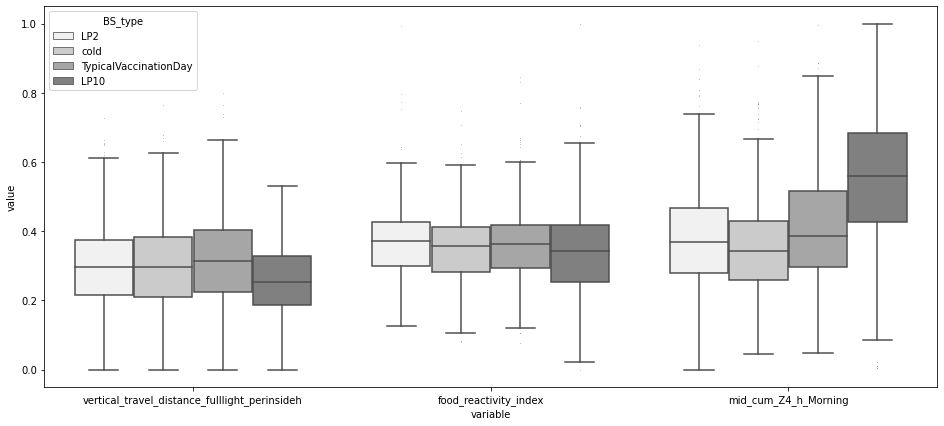

In [60]:
plt.figure(figsize=(16,7))
print(df_BS['BS_type'].unique())
df_plt = df_BS[df_BS['BS_type'].isin(['TypicalVaccinationDay','cold','LP10','LP2'])].copy()
df_plt[li_mvt_cont]=(df_plt[li_mvt_cont]-df_plt[li_mvt_cont].min())/(df_plt[li_mvt_cont].max()-df_plt[li_mvt_cont].min())
df_plt = pd.melt(df_plt, id_vars=['BS_type'], value_vars=li_mvt_cont, value_name = 'value')
display(df_plt.head(3))
sns.boxplot(x="variable", y='value', data=df_plt, hue = 'BS_type', fliersize=0.1, color='grey');
plt.show();

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


,BS_type,variable,value
0,LP2,vertical_travel_distance_fulllight_perinsideh,0.463700
1,LP2,vertical_travel_distance_fulllight_perinsideh,0.393124
2,LP2,vertical_travel_distance_fulllight_perinsideh,0.513624


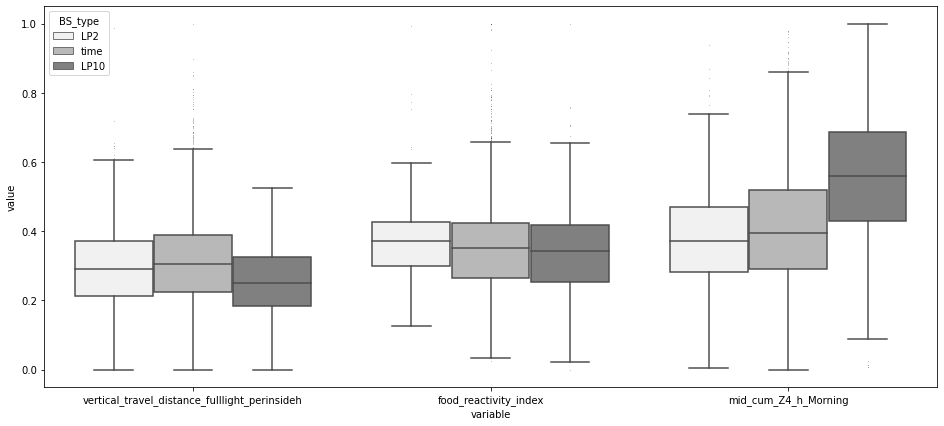

In [61]:
plt.figure(figsize=(16,7))
print(df_BS['BS_type'].unique())
df_plt = df_BS[df_BS['BS_type'].isin(['time','LP10','LP2'])].copy()
df_plt[li_mvt_cont]=(df_plt[li_mvt_cont]-df_plt[li_mvt_cont].min())/(df_plt[li_mvt_cont].max()-df_plt[li_mvt_cont].min())
df_plt = pd.melt(df_plt, id_vars=['BS_type'], value_vars=li_mvt_cont, value_name = 'value')
display(df_plt.head(3))
sns.boxplot(x="variable", y='value', data=df_plt, hue = 'BS_type', fliersize=0.1, color='grey');
plt.show();

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


,DIB,variable,value
0,61,vertical_travel_distance_fulllight_perinsideh,0.463700
1,68,vertical_travel_distance_fulllight_perinsideh,0.393124
2,75,vertical_travel_distance_fulllight_perinsideh,0.513624


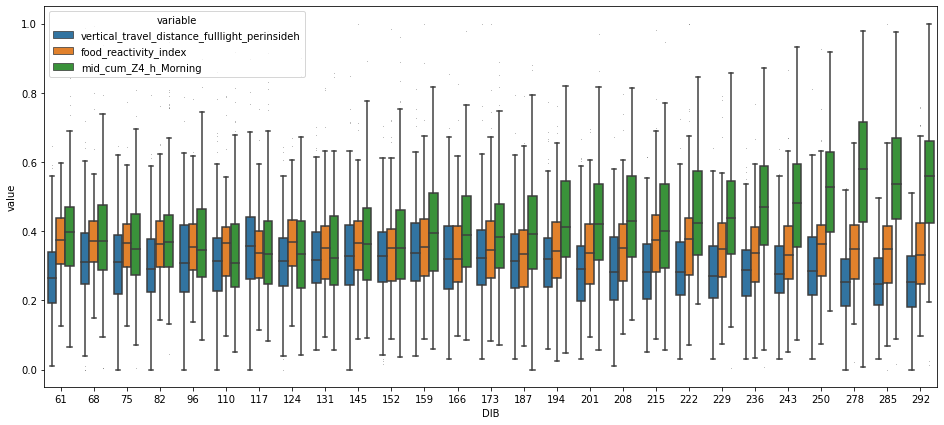

In [62]:
plt.figure(figsize=(16,7))
print(df_BS['BS_type'].unique())
df_plt = df_BS[df_BS['BS_type'].isin(['time','LP10','LP2'])].copy()
df_plt[li_mvt_cont]=(df_plt[li_mvt_cont]-df_plt[li_mvt_cont].min())/(df_plt[li_mvt_cont].max()-df_plt[li_mvt_cont].min())
df_plt = pd.melt(df_plt, id_vars=['DIB'], value_vars=li_mvt_cont, value_name = 'value')
display(df_plt.head(3))
sns.boxplot(x="DIB", y='value', data=df_plt, hue = 'variable', fliersize=0.1);
plt.show();

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


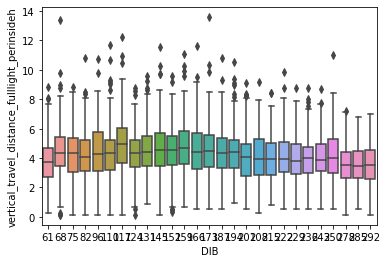

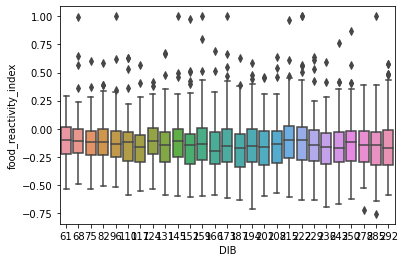

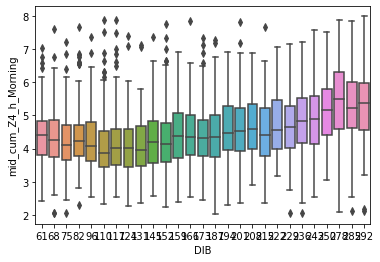

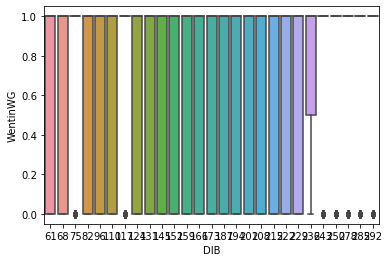

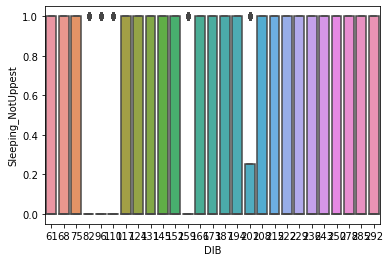

In [63]:
print(df_BS['BS_type'].unique())
df_plt = df_BS[df_BS['BS_type'].isin(['time','LP10','LP2'])].copy()
for m in li_mvt_cont+li_mvt_bin:
    sns.boxplot(x="DIB", y=m, data=df_plt);
    plt.show();

# visualise behavior / hen

#### continuous mvt var

In [66]:
#initialise hens, list if mvt
#same color and different context (OR: coul dhave kept order and use no color, but we wouldn't illustratethe repeabtaitliy 
#within context)
#chose palette: https://seaborn.pydata.org/tutorial/color_palettes.html
df_ = df_BS[df_BS['across_context']==1].groupby(['HenID'])['level'].count().reset_index()
li_hen_plot = df_[df_['level']==4]['HenID'].tolist()
print('We will visualise the %d hens that are in all across_context observation (and thus also that are in all context at least one time)'%len(li_hen_plot))
#&(df_BS['PenID']=='pen10')
df_BS_plt = df_BS[(df_BS['HenID'].isin(li_hen_plot))][['level','DOA','DIB','BS_type','Treatment','PenID','HenID_WIB','HenID',
                                                       'across_context']+li_mvt_cont+li_mvt_bin].copy()

We will visualise the 109 hens that are in all across_context observation (and thus also that are in all context at least one time)


In [87]:
#dataframe to be able to sort hens by mean behavior over the time context only
df_plt = df_BS_plt[df_BS_plt['BS_type']=='time'].groupby(['HenID'])[li_mvt_cont+li_mvt_bin].median().reset_index()
print(df_plt.shape)
df_plt.head(3)

(109, 6)


,HenID,vertical_travel_distance_fulllight_perinsideh,food_reactivity_index,mid_cum_Z4_h_Morning,WentinWG,Sleeping_NotUppest
0,hen_10,3.043968,0.032008,3.845833,0.0,1.0
1,hen_101,4.428296,-0.140683,4.537222,1.0,1.0
2,hen_102,2.747101,-0.069980,4.053333,1.0,0.0


In [69]:
#select 5 random hens and associate them to a nice color
random.seed(1)
li_all_hen = df_plt['HenID'].tolist()
li_hen_visual = random.choices(li_all_hen, k=5)
print(li_hen_visual)
pal_ = {henID:'grey' for henID in li_all_hen}
li_nicecolor_brighter = ['mediumblue','deeppink','goldenrod','green','cyan','yellow']
for i,henID in enumerate(li_hen_visual):
    pal_[henID] = li_nicecolor_brighter[i]

['hen_128', 'hen_68', 'hen_58', 'hen_150', 'hen_188']


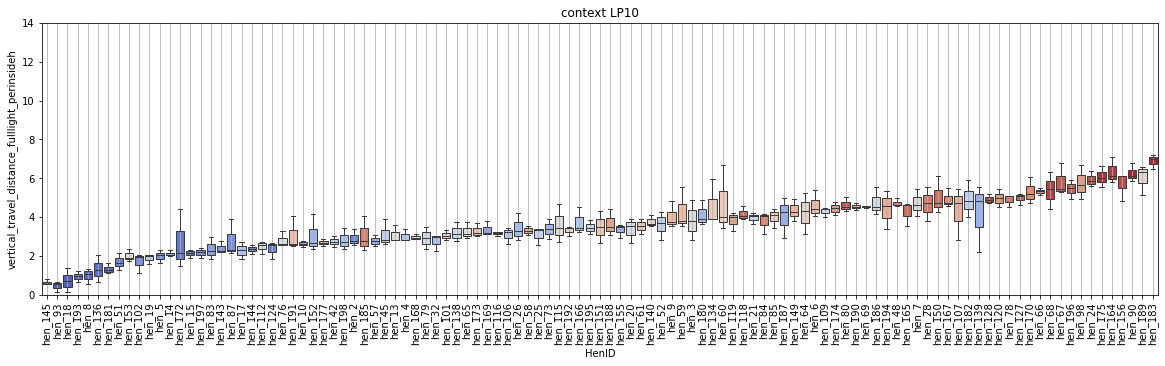

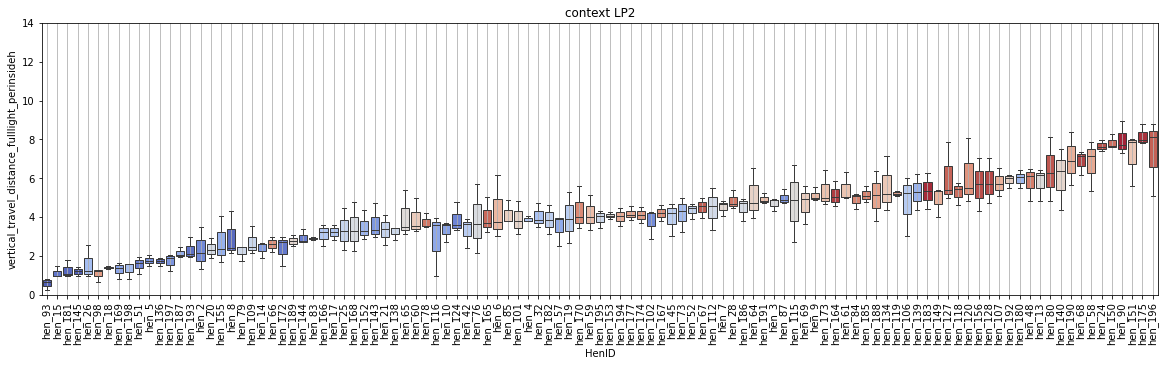

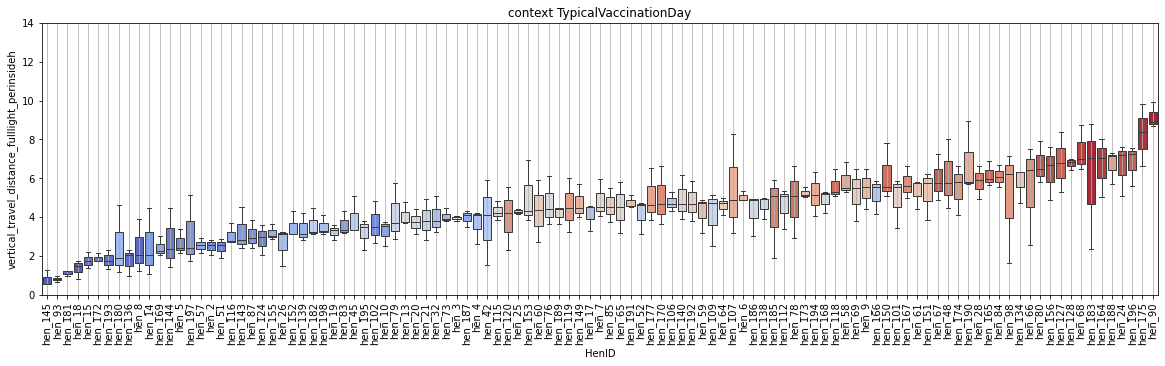

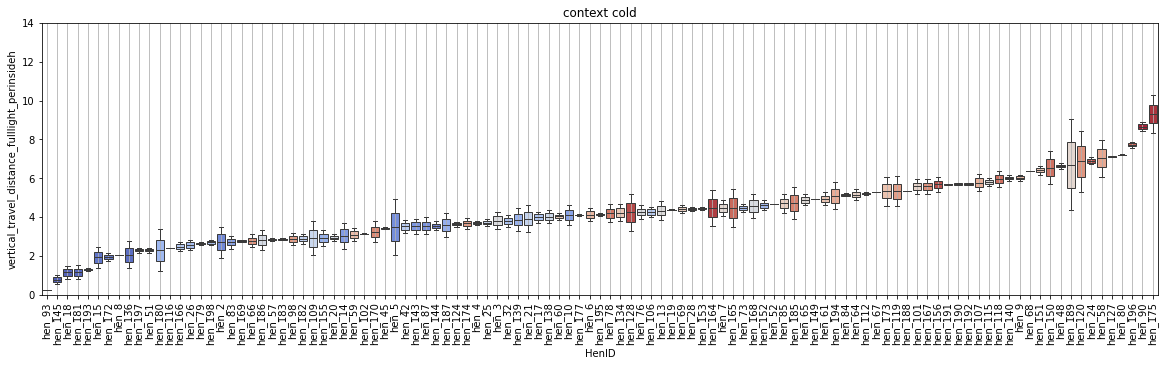

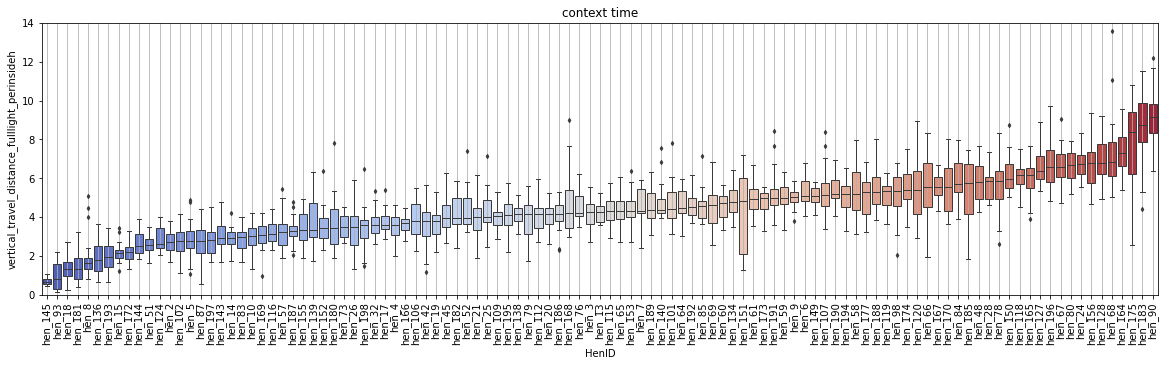

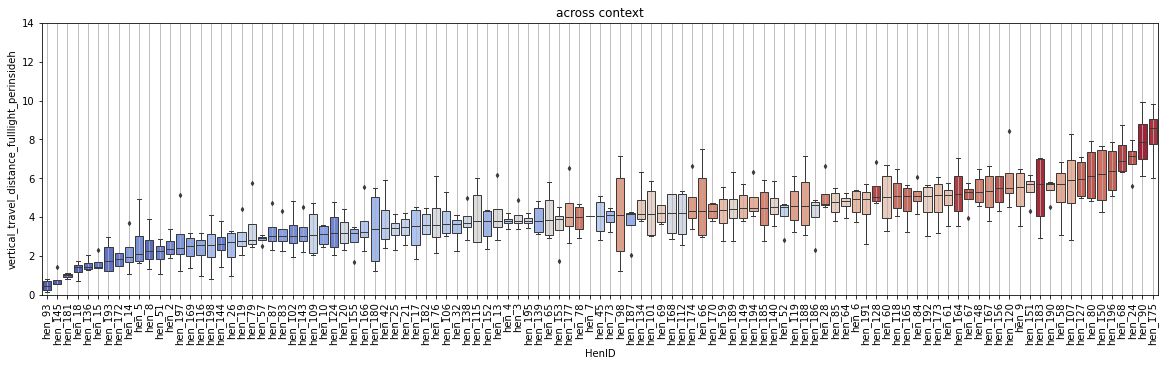

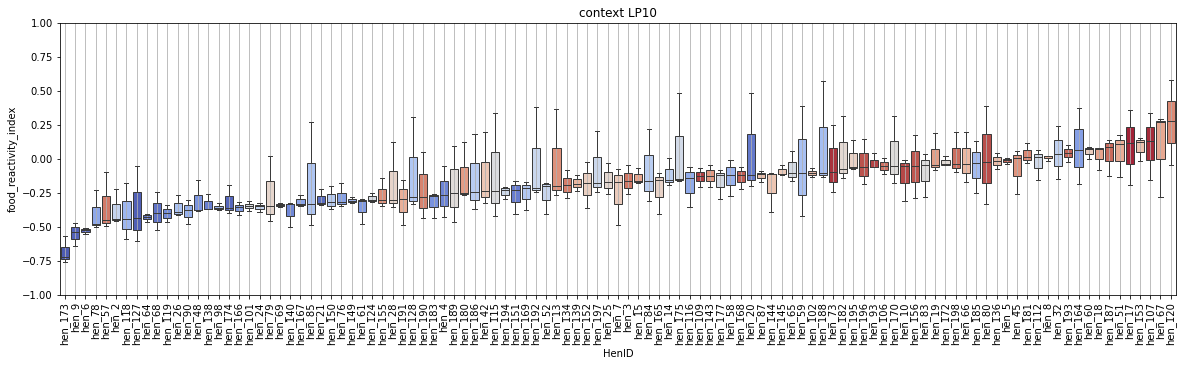

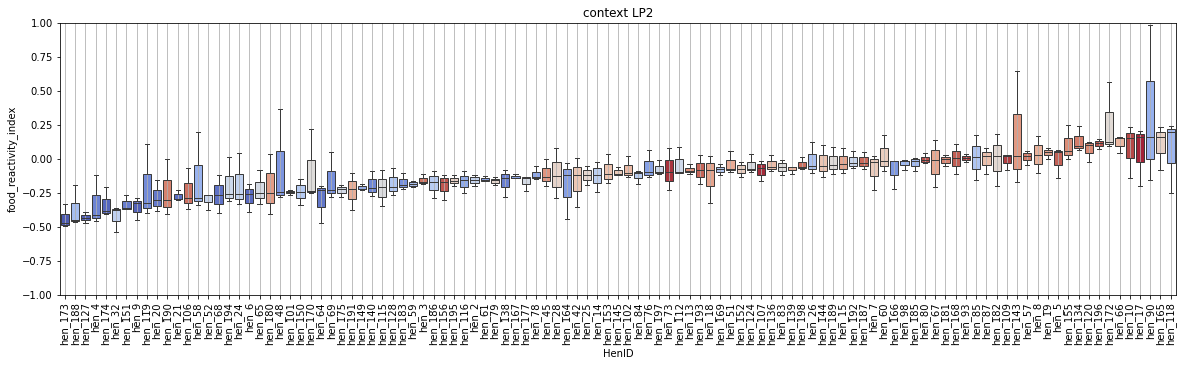

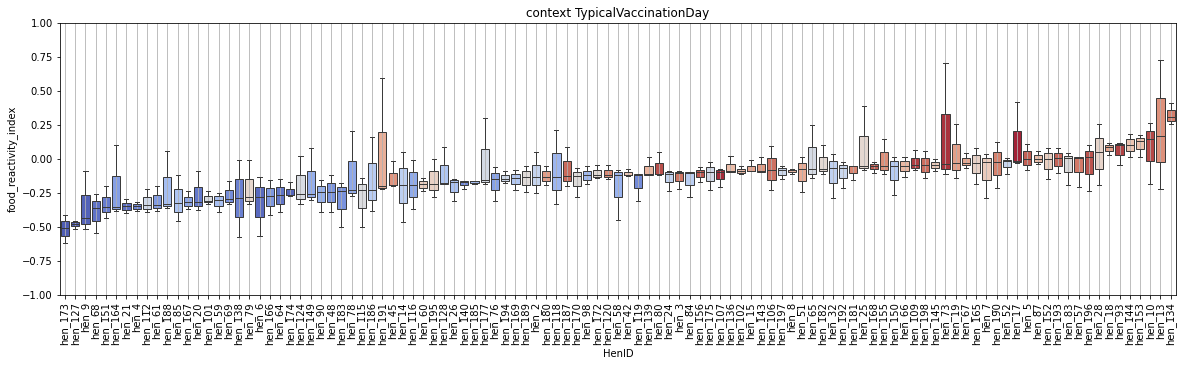

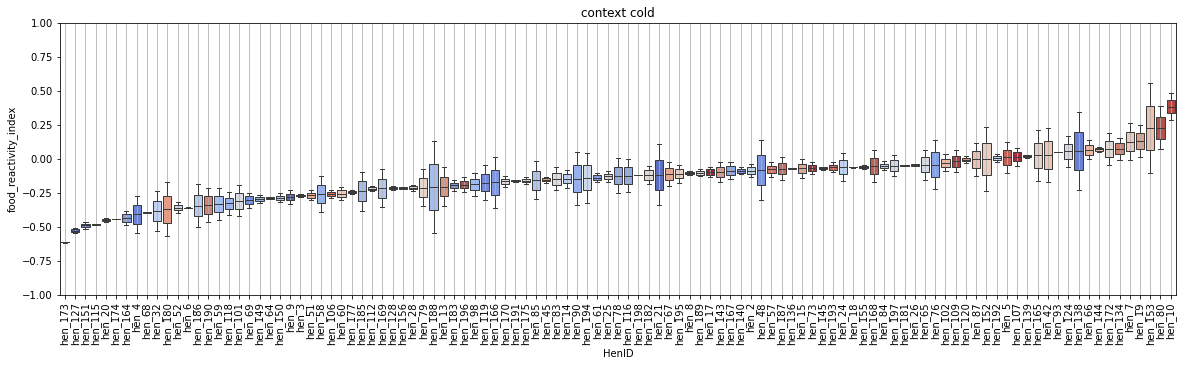

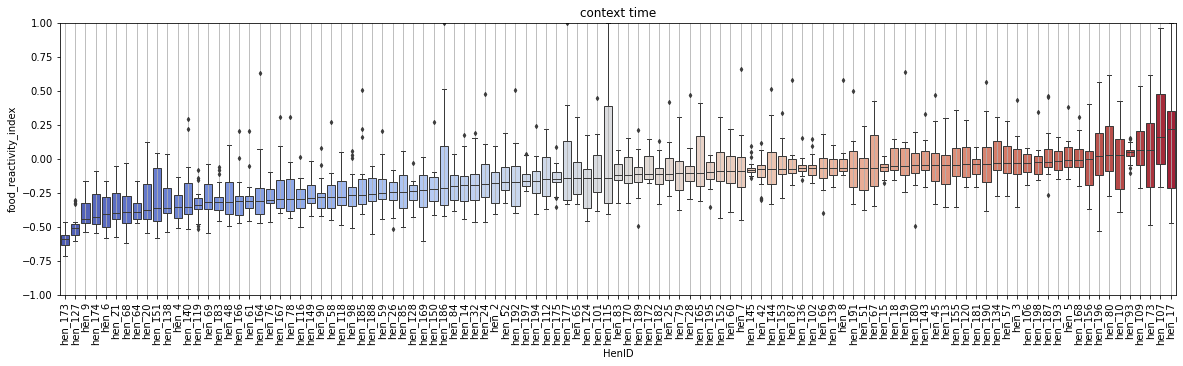

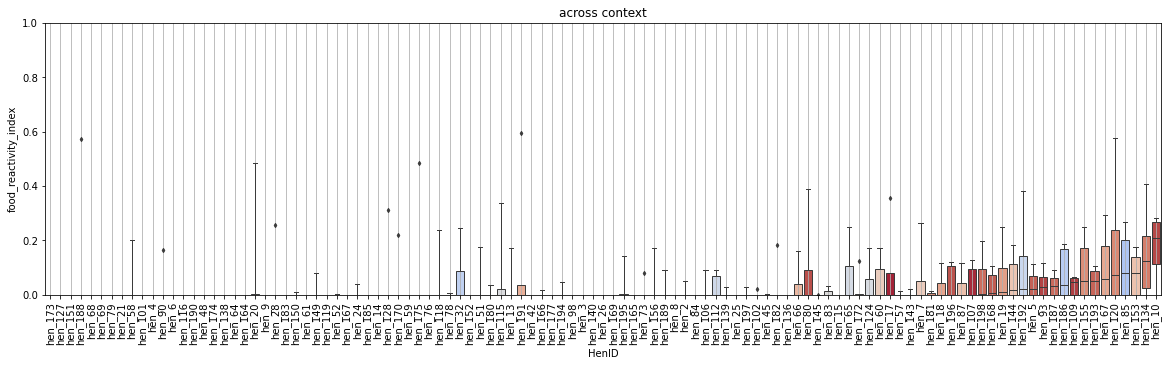

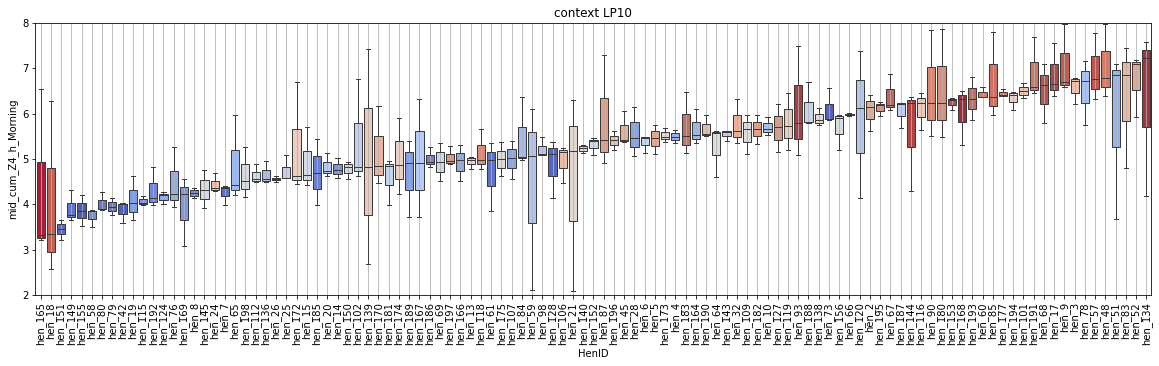

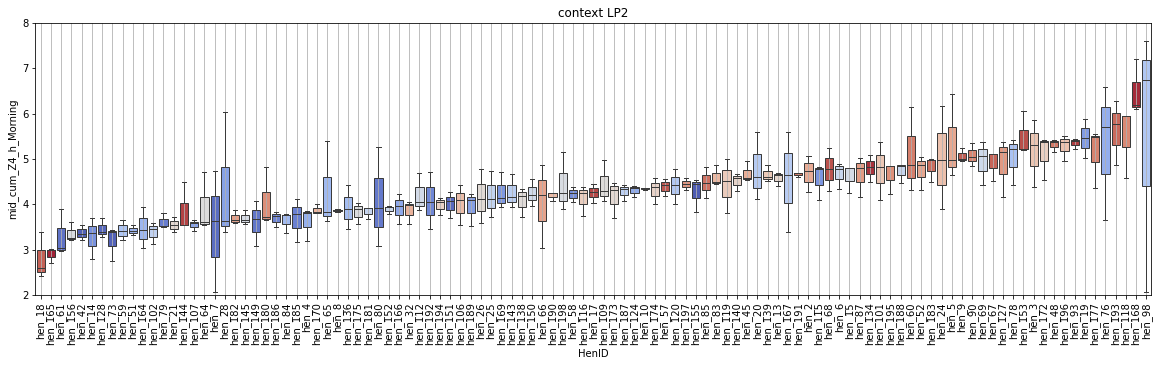

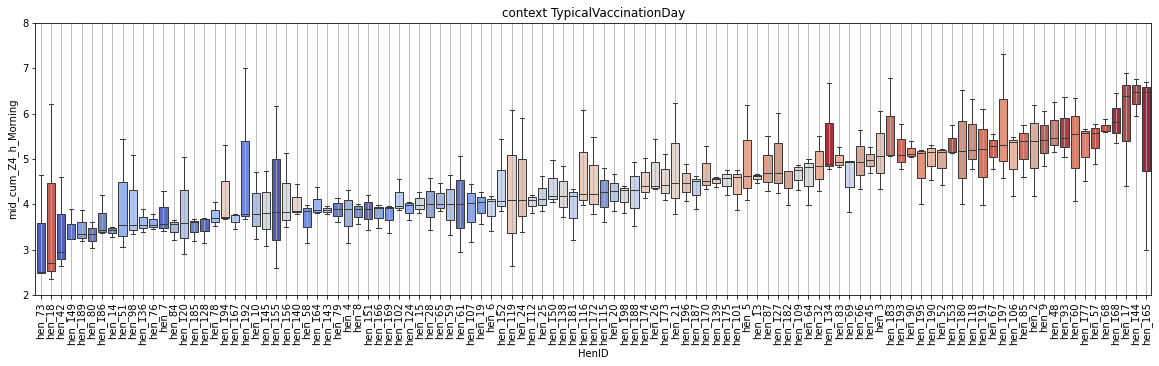

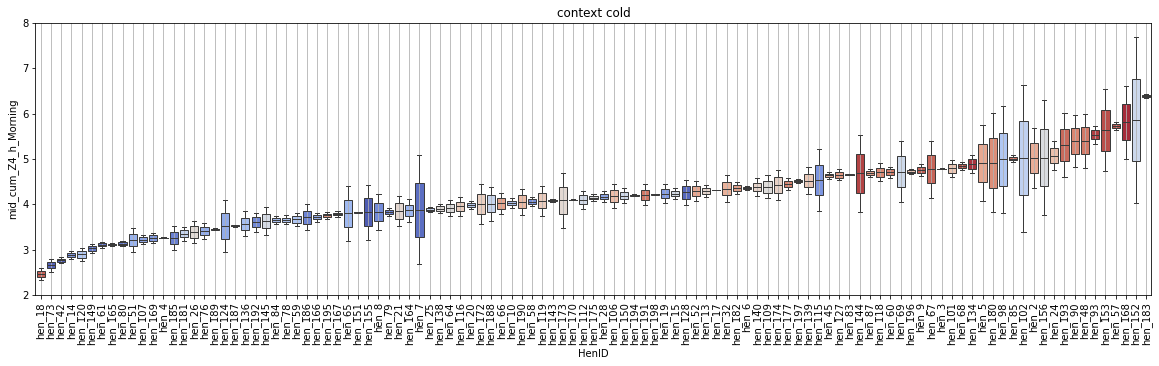

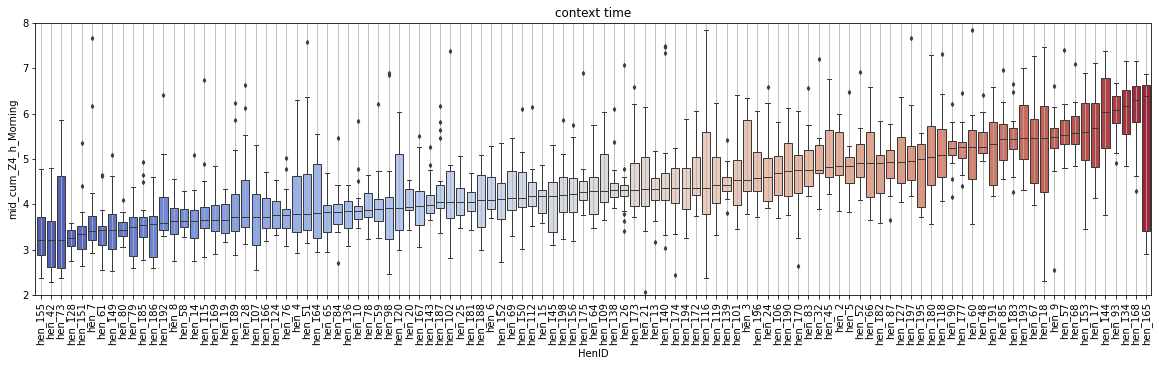

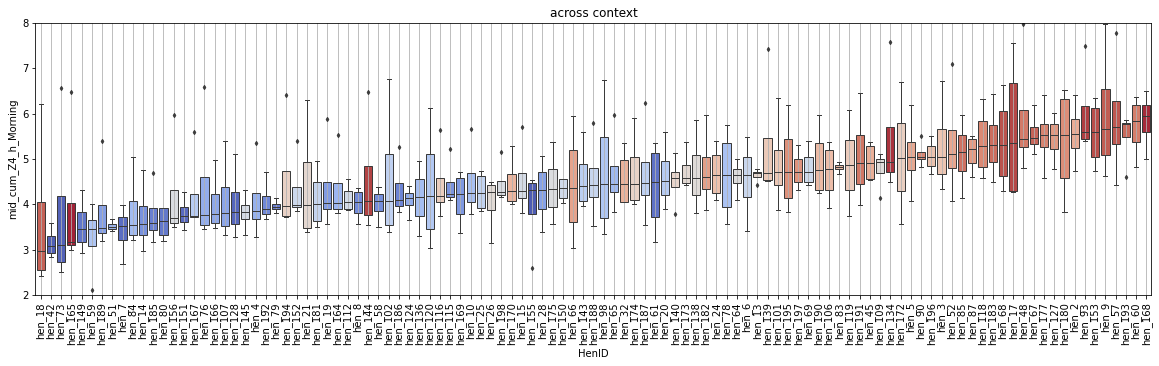

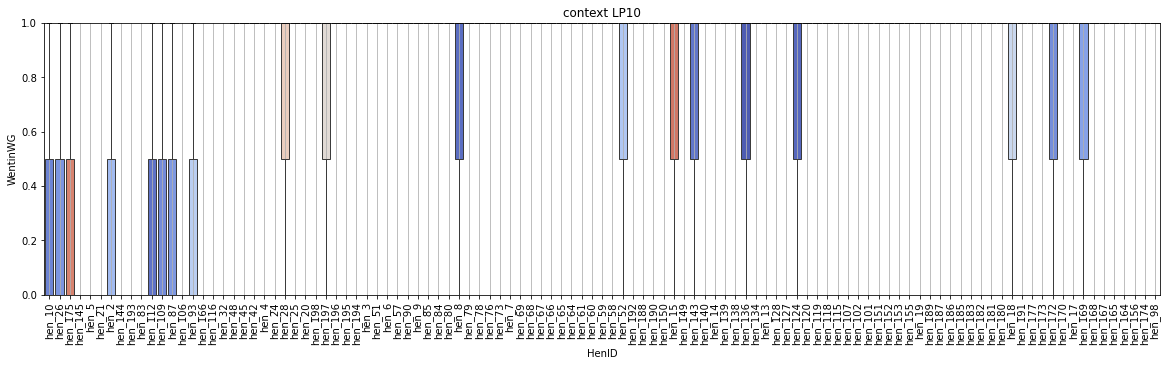

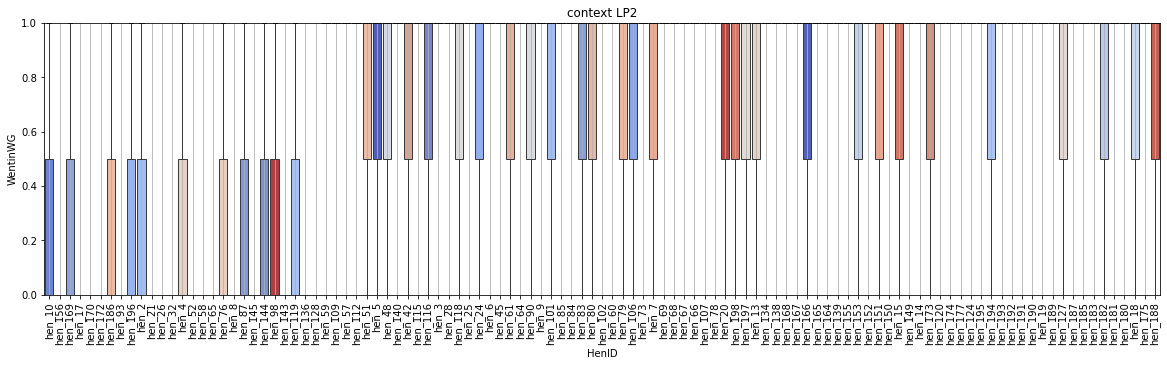

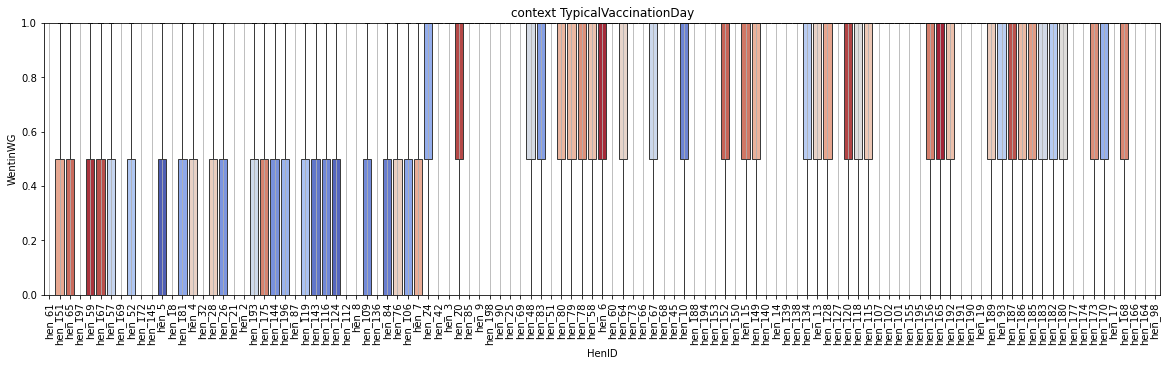

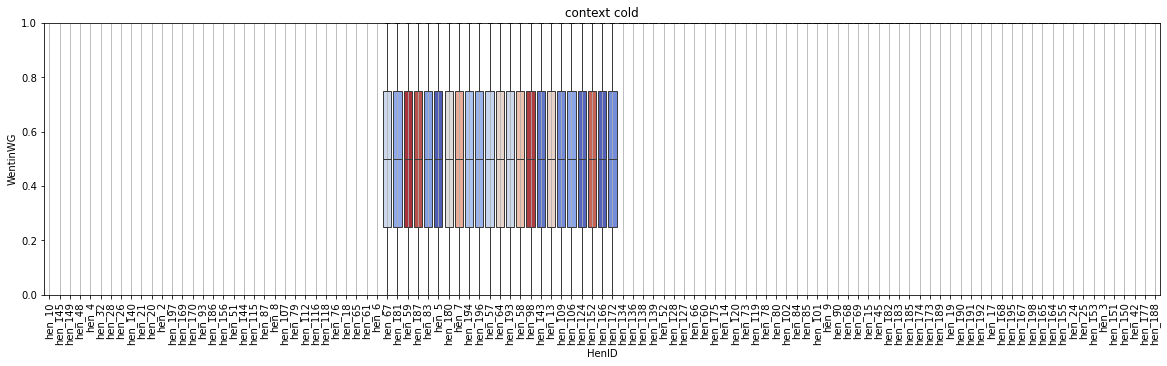

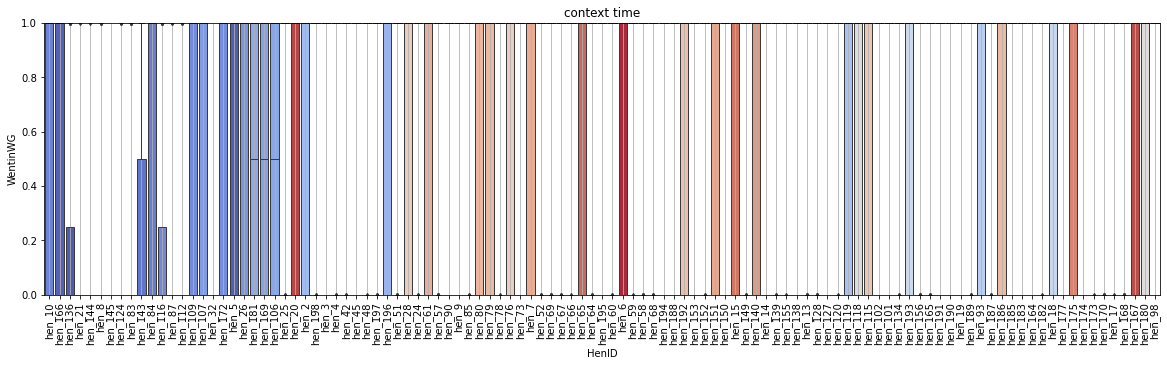

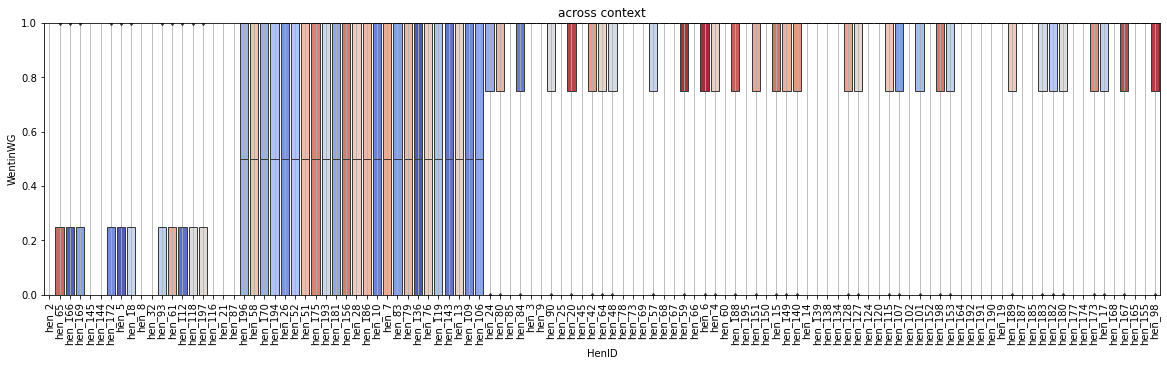

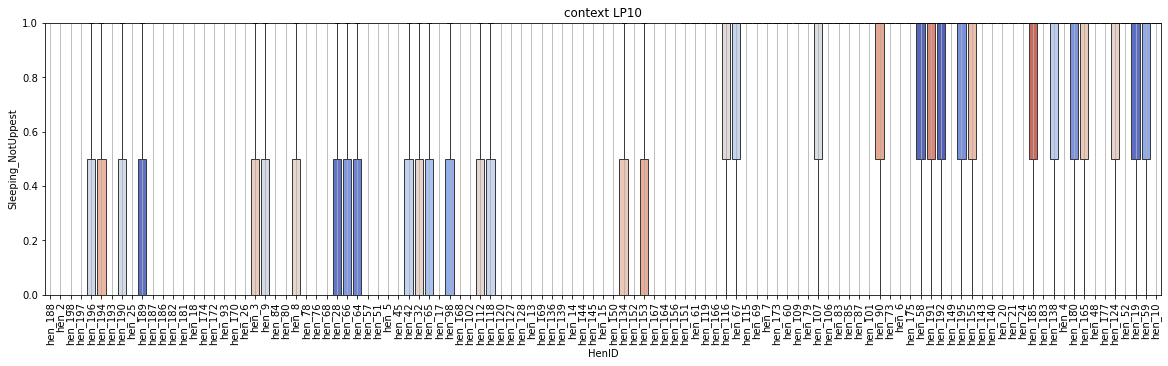

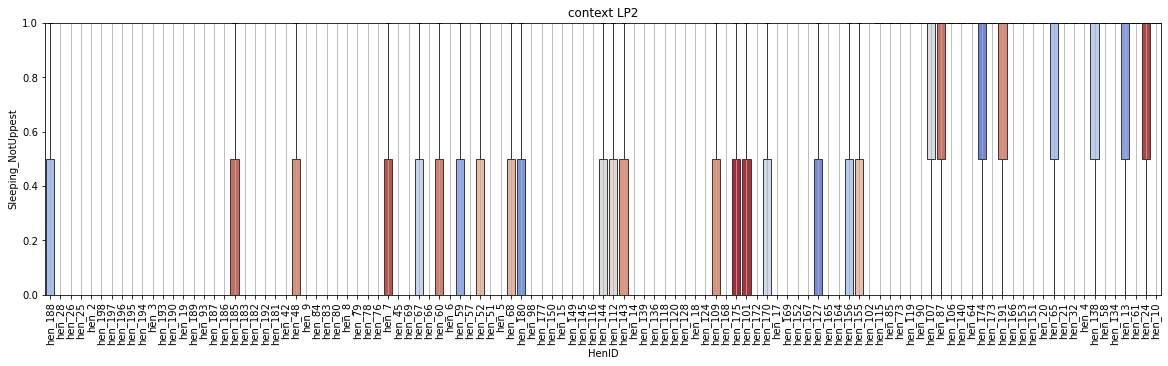

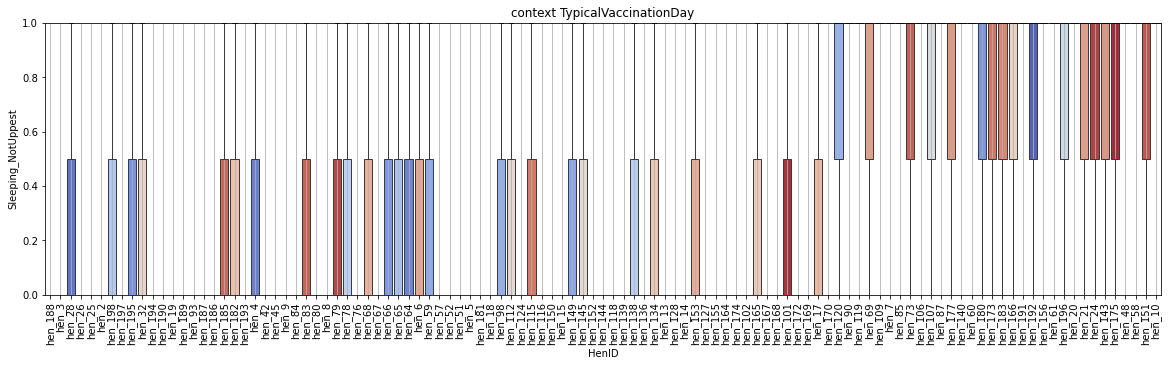

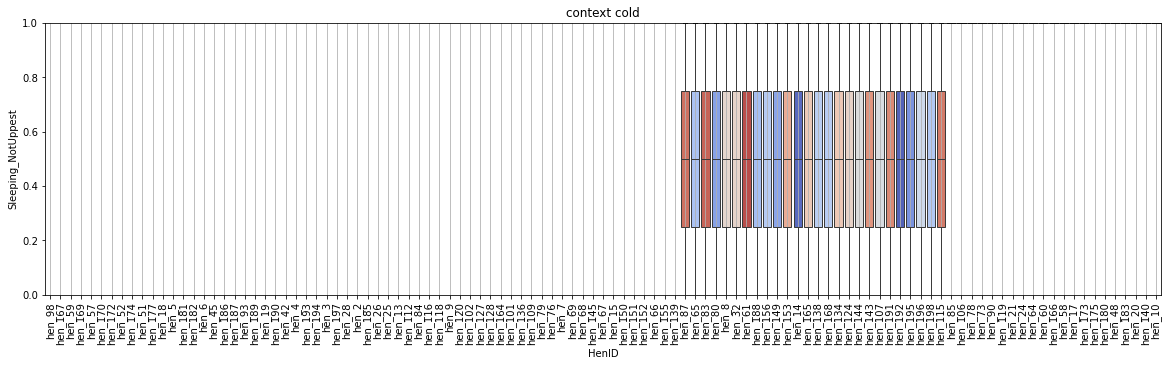

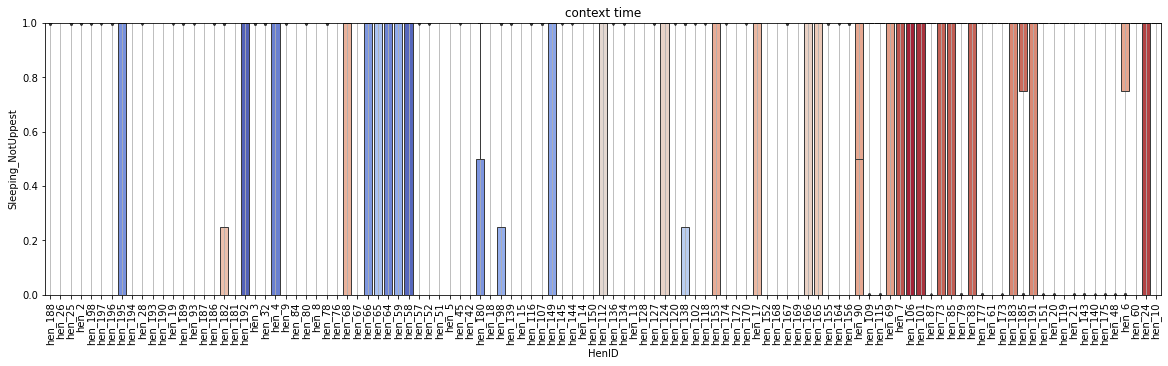

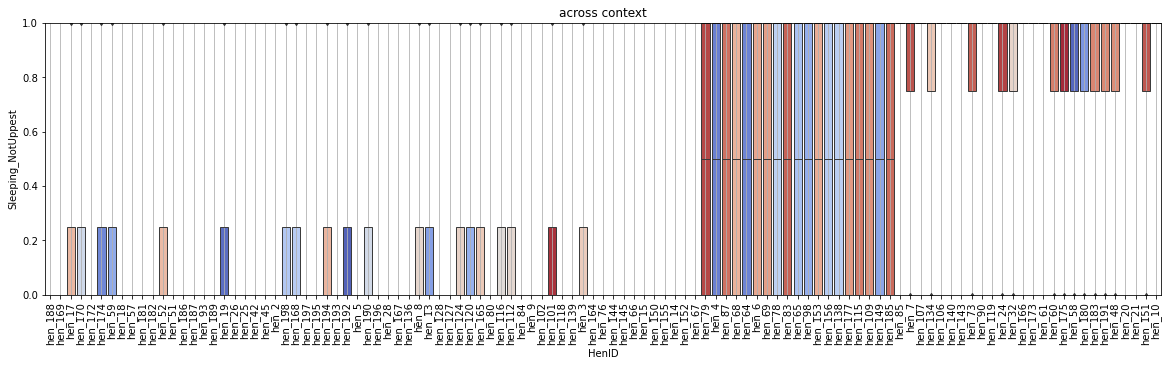

In [92]:
#dico_mvt_R = []
#'R = 0.38, 95%-CI [0.29, 0.44]'
#mvt = 'vertical_travel_distance_fulllight_perinsideh'
for mvt in li_mvt_cont+li_mvt_bin:
    
    #choose color of hens based on the particular mvt variable, as sorted in the datafrmae based on the time context
    li_hen_sort = df_plt.sort_values([mvt])['HenID'].tolist()
    li_color = sns.color_palette("coolwarm",n_colors=len(df_plt['HenID'])) #flare, coolwarm,viridis
    df_plt = df_plt.sort_values(mvt)
    dico_hen_color =  dict(zip(df_plt['HenID'].tolist(), li_color))
        
    ### within context
    #for each context sort hens and plot with color as sorted by over time context
    for t, df_ in df_BS_plt.groupby(['BS_type']):
        #sort hens for that specific context based on the median to match the boxplot line
        df_plt_ = df_.groupby(['HenID'])[mvt].median().reset_index()
        li_hen_sort_ = df_plt_.sort_values([mvt])['HenID'].tolist()
        df_['sorted'] = df_['HenID'].map(lambda x: li_hen_sort_.index(x))
        df_ = df_.sort_values('sorted')
        plt.figure(figsize=(20,5))
        #plt.text(2, 10.6, 'R = 0.38, 95%-CI [0.29, 0.44]', color='black', size='x-large')
        plt.grid()
        ax = sns.boxplot(x='HenID', y=mvt, data=df_, color='grey', palette=dico_hen_color, fliersize=3, linewidth=1);
        plt.grid()
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
        plt.title('context '+t)
        plt.ylim((math.floor(df_BS_plt[mvt].min()),math.ceil(df_BS_plt[mvt].max())))
        plt.savefig(os.path.join(path_extracted_data ,'BS_'+mvt+'_'+t+'.png'), bbox_inches='tight')
        plt.show();

    ### across context
    df_ = df_BS_plt[df_BS_plt['across_context']==1].copy()
    df_plt_ = df_.groupby(['HenID'])[mvt].median().reset_index()
    li_hen_sort_ = df_plt_.sort_values([mvt])['HenID'].tolist()
    df_['sorted'] = df_['HenID'].map(lambda x: li_hen_sort_.index(x))
    df_ = df_.sort_values('sorted')
    plt.figure(figsize=(20,5))
    #plt.text(2, 10.6, 'R = 0.38, 95%-CI [0.29, 0.44]', color='black', size='x-large')
    plt.grid()
    ax = sns.boxplot(x='HenID', y=mvt, data=df_, color='grey', palette=dico_hen_color, fliersize=3, linewidth=1);
    plt.grid()
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
    plt.title('across context')
    plt.ylim((int(df_BS_plt[mvt].min()),math.ceil(df_BS_plt[mvt].max())))
    plt.savefig(os.path.join(path_extracted_data ,'BS_'+mvt+'_acrosscontext.png'), bbox_inches='tight')
    plt.show();

#### Binary mvt var

In [72]:
#dataframe to be able to sort hens by mean behavior over the time context only
df_plt_binary = df_BS_plt[df_BS_plt['BS_type']=='time'].groupby(['HenID'])[li_mvt_bin].mean().reset_index()
df_plt_binary['Sleeping_NotUppest_perc'] = df_plt_binary['Sleeping_NotUppest'].map(lambda x: x*100)
print(df_plt_binary.shape)
df_plt_binary.head(3)

(109, 4)


,HenID,WentinWG,Sleeping_NotUppest,Sleeping_NotUppest_perc
0,hen_10,0.333333,1.000000,100.000000
1,hen_101,1.000000,0.523810,52.380952
2,hen_102,1.000000,0.047619,4.761905


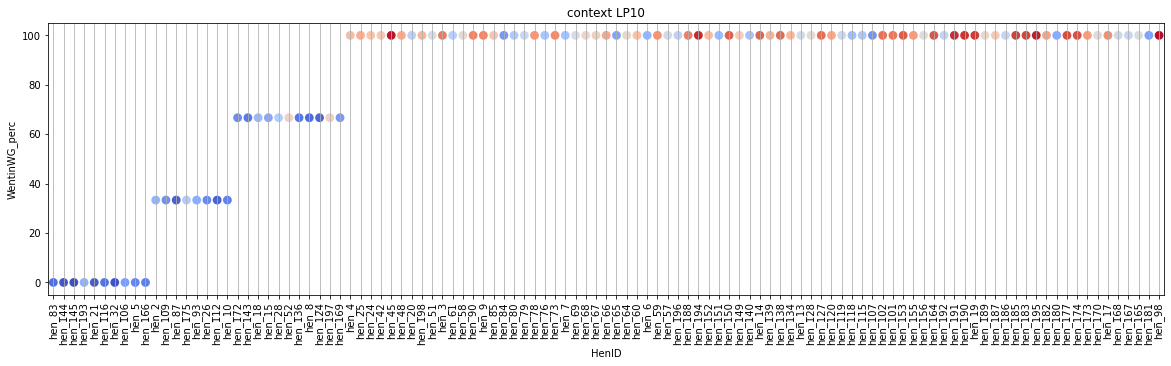

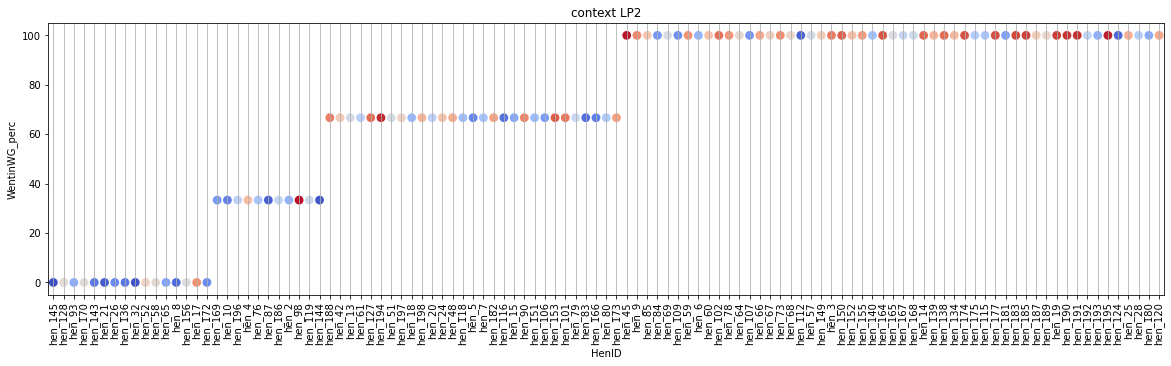

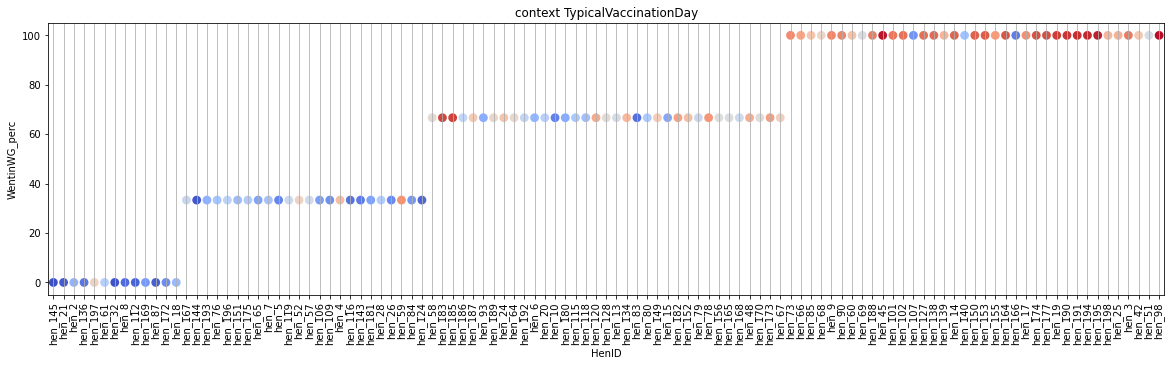

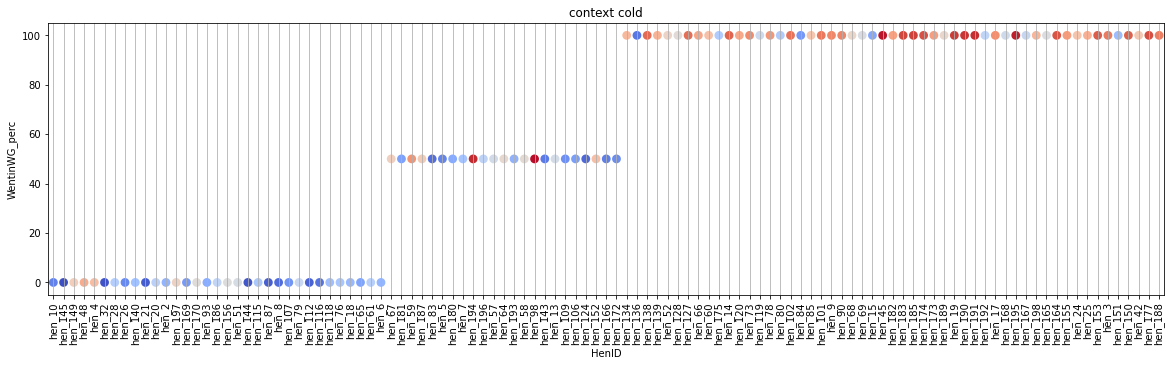

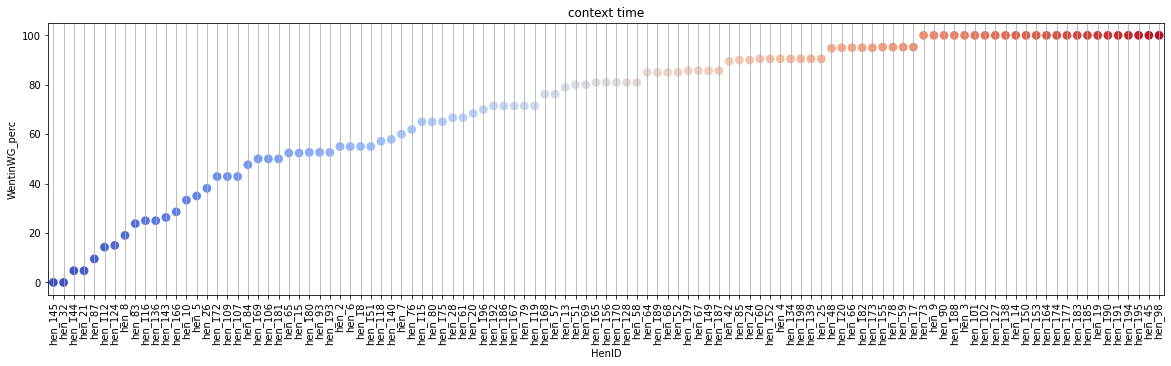

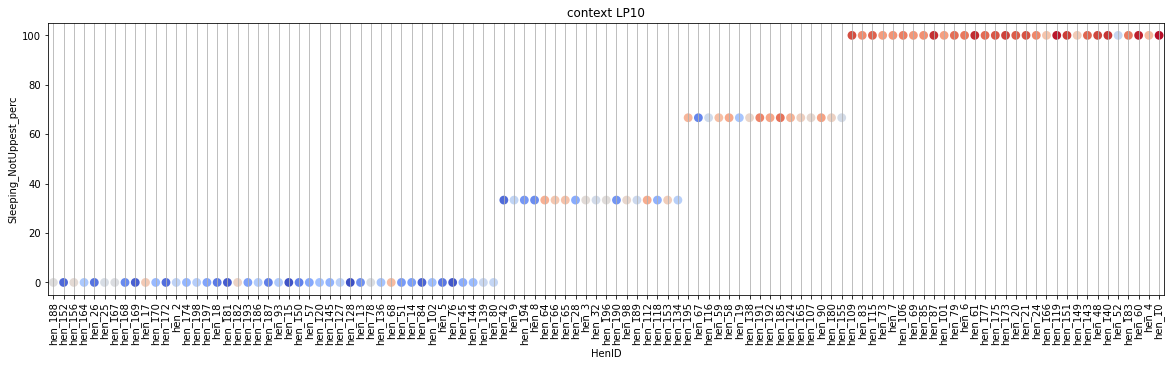

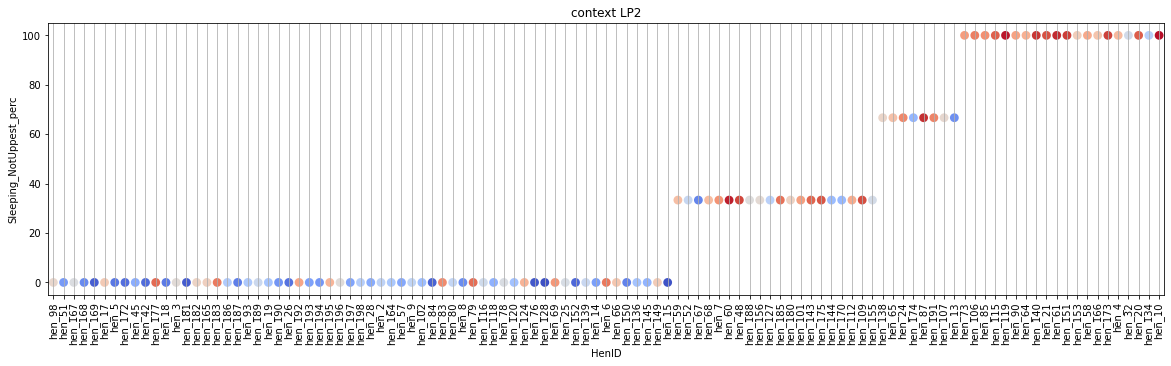

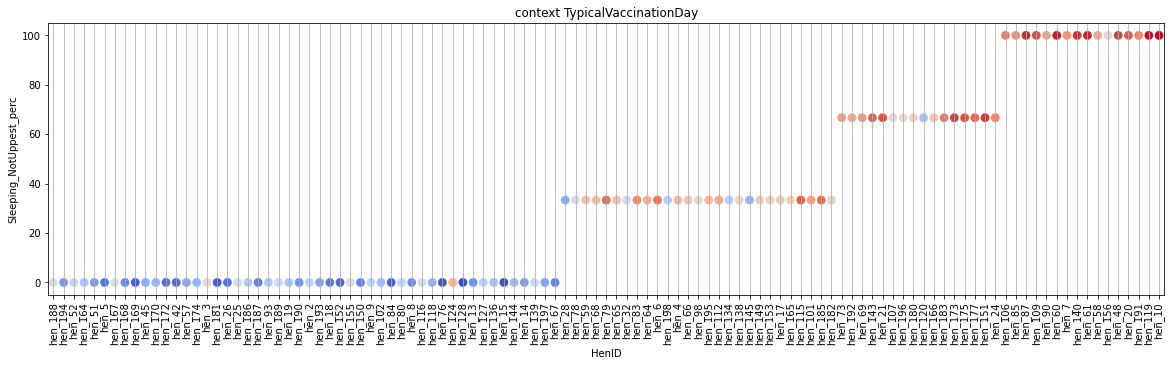

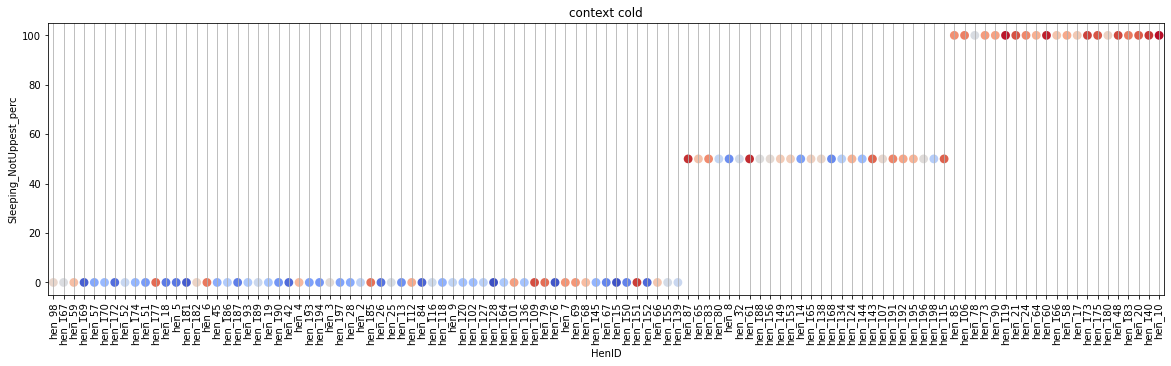

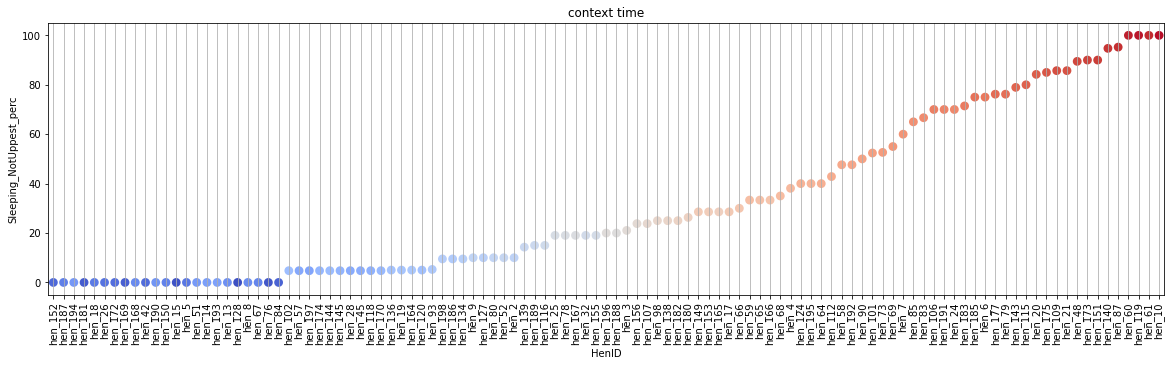

In [73]:
#dico_mvt_R = []
#'R = 0.38, 95%-CI [0.29, 0.44]'
#mvt = 'vertical_travel_distance_fulllight_perinsideh'
for mvt in li_mvt_bin:
    
    #choose color of hens based on the particular mvt variable, as sorted in the dataframe based on the time context
    li_hen_sort = df_plt_binary.sort_values([mvt])['HenID'].tolist()
    li_color = sns.color_palette("coolwarm",n_colors=len(df_plt_binary['HenID'])) #flare, coolwarm,viridis
    df_plt_binary = df_plt_binary.sort_values(mvt)
    dico_hen_color =  dict(zip(df_plt_binary['HenID'].tolist(), li_color))
    
    #for each context sort hens and plot with color as sorted by over time context
    for t, df_ in df_BS_plt.groupby(['BS_type']):
        #sort hens for that specific context
        df_plt_ = df_.groupby(['HenID'])[mvt].mean().reset_index()
        df_plt_[mvt+'_perc'] = df_plt_[mvt].map(lambda x: x*100)
        df_plt_ = df_plt_.sort_values([mvt+'_perc'])
        plt.figure(figsize=(20,5))
        #plt.text(2, 10.6, 'R = 0.38, 95%-CI [0.29, 0.44]', color='black', size='x-large')
        plt.grid()
        ax = sns.pointplot(x='HenID', y=mvt+'_perc', data=df_plt_, color='grey', palette=dico_hen_color);
        plt.grid()
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
        plt.title('context '+t)
        plt.savefig(os.path.join(path_extracted_data ,'BS_'+mvt+'_'+t+'.png'), bbox_inches='tight')
        plt.show();

# visualise behavior associations

--------------------------------------------------------------------------


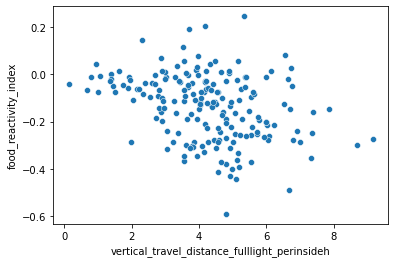

(-0.3356027714075489, 2.207417169117929e-06)
SpearmanrResult(correlation=-0.3483884230646424, pvalue=8.40540731956877e-07)
--------------------------------------------------------------------------


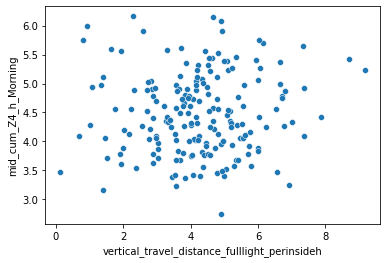

(0.05323338165660835, 0.4657283822719435)
SpearmanrResult(correlation=0.046270125575719405, pvalue=0.5261326597269009)
--------------------------------------------------------------------------


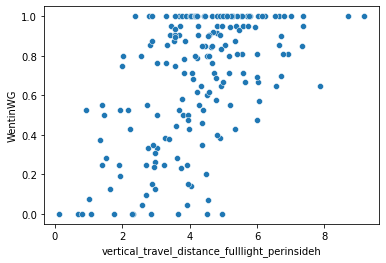

(0.5348355333905057, 1.8852113157778858e-15)
SpearmanrResult(correlation=0.4876109078990331, pvalue=9.67281698144531e-13)
--------------------------------------------------------------------------


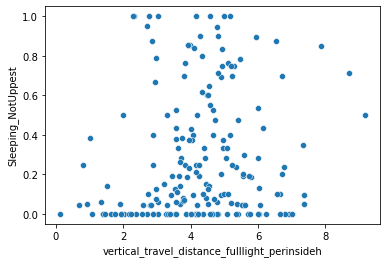

(0.14051128835231924, 0.05315772026128312)
SpearmanrResult(correlation=0.15899636576196113, pvalue=0.028443927490124424)
--------------------------------------------------------------------------


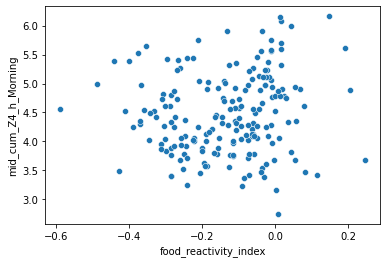

(0.11450230456252702, 0.11570299084442454)
SpearmanrResult(correlation=0.14519807371832724, pvalue=0.04562834532446347)
--------------------------------------------------------------------------


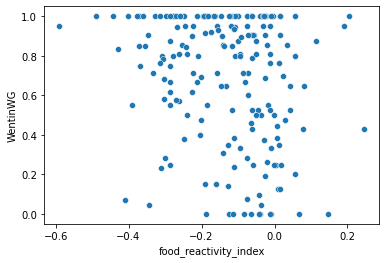

(-0.2299588134215716, 0.0014142308527334577)
SpearmanrResult(correlation=-0.22588709213179461, pvalue=0.0017261969889047805)
--------------------------------------------------------------------------


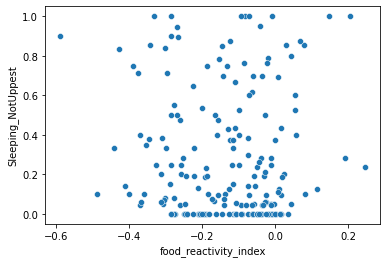

(-0.040424089012617376, 0.5797451240546417)
SpearmanrResult(correlation=-0.07211951521542476, pvalue=0.322747696338603)
--------------------------------------------------------------------------


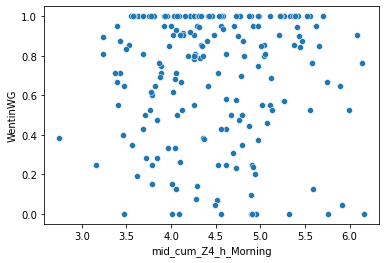

(-0.00434666669300513, 0.9525382768991772)
SpearmanrResult(correlation=0.022920824765996488, pvalue=0.7535984112051557)
--------------------------------------------------------------------------


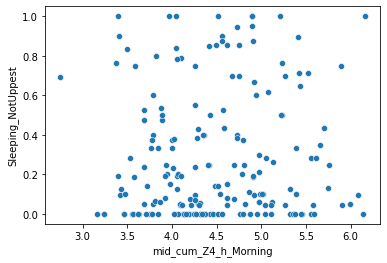

(0.047698245393203796, 0.5134285757508534)
SpearmanrResult(correlation=0.0634624550956428, pvalue=0.3843691169991549)
--------------------------------------------------------------------------


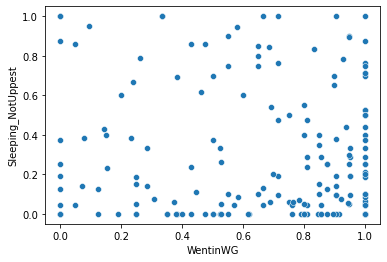

(-0.09550776037374598, 0.1899271345913443)
SpearmanrResult(correlation=-0.061556323381846655, pvalue=0.39883894519411467)


In [75]:
from scipy.stats import pearsonr, spearmanr
#in case but we are not studying this
#sns.scatterplot(data=df_BS.groupby(['HenID','BS_type']).mean().reset_index(), x="vertical_travel_distance_fulllight_perinsideh", 
#                y="food_related_behavior_final", hue='BS_type')
li_mvt = li_mvt_cont + li_mvt_bin
for i in range(0,len(li_mvt)-1):
    for j in range(i+1,len(li_mvt)):
        print('--------------------------------------------------------------------------')
        df_plt = df_BS[df_BS['BS_type']=='time'].groupby(['HenID']).mean().reset_index()
        sns.scatterplot(data=df_plt,
                        x=li_mvt[i],  y=li_mvt[j])#,  size="size", sizes=(20, 200))
        plt.show();
        print(pearsonr(df_plt[li_mvt[i]].tolist(), df_plt[li_mvt[j]].tolist()))
        print(spearmanr(df_plt[li_mvt[i]].tolist(), df_plt[li_mvt[j]].tolist()))

# visualise food reactivity index

In [5]:
df_BS = pd.read_csv(os.path.join(path_extracted_data,'df_BS.csv'), sep=',')
df_BS.head(3)

,TrackingSystemID,level,DOA,DIB,FoodPenID,BS_type,Treatment,CLASS,PenID,temperature_C_avg,...,across_context,KBF_interp,weight_interp,WentinWG,mid_cum_Z4_h_Morning,Sleeping_NotUppest,vertical_travel_distance_fulllight_perinsideh,food_reactivity_index,food_reactivity_index_backward,food_reactivity_index_forward
0,TrackingSystem 10-12,2020-11-29,179,61,FoodPenID9-12,LP2,TRAN,REXP,pen10,2.166667,...,1,0.0,1747.700000,1,4.028333,0,6.366423,-0.265963,-0.043005,0.099815
1,TrackingSystem 10-12,2020-12-06,186,68,FoodPenID9-12,LP2,TRAN,REXP,pen10,2.166667,...,0,0.0,1766.016667,1,4.046389,0,5.418036,-0.180666,-0.176871,-0.030522
2,TrackingSystem 10-12,2020-12-13,193,75,FoodPenID9-12,LP2,TRAN,REXP,pen10,5.833333,...,0,0.0,1784.333333,1,3.921667,0,7.037298,-0.164500,0.393621,0.050599


,HenID,level,PenID,variable,food_behavior,is_negative
0,hen_131,2020-11-29,pen10,food_reactivity_index,-0.265963,1
1,hen_131,2020-12-06,pen10,food_reactivity_index,-0.180666,1
2,hen_131,2020-12-13,pen10,food_reactivity_index,-0.164500,1


,variable,level,is_negative
0,food_reactivity_index,2020-11-29,71.710526
1,food_reactivity_index,2020-12-06,75.816993
2,food_reactivity_index,2020-12-13,81.578947


,variable,mean_is_negative,sd_is_negative
0,food_reactivity_index,77.326774,3.175716
1,food_reactivity_index_backward,53.963204,6.803370
2,food_reactivity_index_forward,54.877414,4.996032


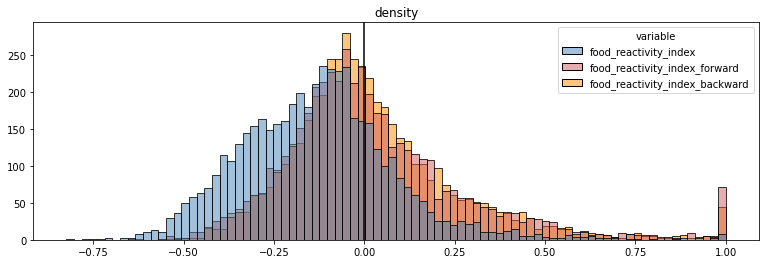

In [7]:
df_plt = pd.melt(df_BS, id_vars=['HenID','level','PenID'], 
        value_vars=['food_reactivity_index','food_reactivity_index_forward','food_reactivity_index_backward'],
        value_name='food_behavior')
df_plt['is_negative'] = df_plt['food_behavior'].map(lambda x: int(x<0))
display(df_plt.head(3))
df_plt_ = df_plt.groupby(['variable','level'])['is_negative'].agg(lambda x: sum(x)/len(x)*100).reset_index()
display(df_plt_.head(3))
display(df_plt_.groupby(['variable']).agg(mean_is_negative=pd.NamedAgg(column='is_negative', aggfunc=lambda x: np.nanmean(x)),
           sd_is_negative=pd.NamedAgg(column='is_negative', aggfunc=lambda x: np.std(x))).reset_index())
#weekly average +-SD of the mean daily food-related behavior across individuals
plt.figure(figsize=(13,4))
pal_ = {'food_reactivity_index_backward':'darkorange',
        'food_reactivity_index_forward':'indianred',
        'food_reactivity_index':'steelblue'}
sns.histplot(df_plt, x='food_behavior', kde=False, hue='variable', palette=pal_);
plt.ylabel('')
plt.xlabel('')
plt.title('density')
plt.axvline(0, color='black');
plt.savefig(os.path.join(path_extracted_data, 'dfBS_FoodRI_density.png'),dpi=300,format='png',bbox_inches='tight')

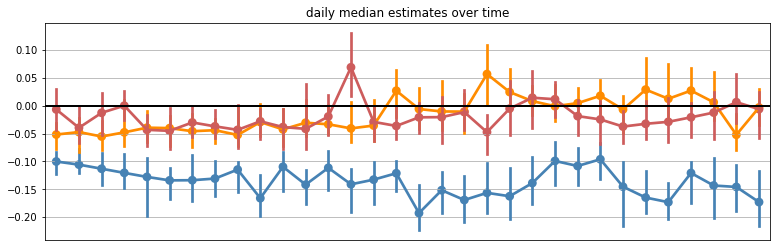

In [8]:
plt.figure(figsize=(13,4))
sns.pointplot(y='food_reactivity_index', x='DIB', color=pal_['food_reactivity_index'], data=df_BS, 
              estimator=np.median);
sns.pointplot(y='food_reactivity_index_backward', x='DIB', color=pal_['food_reactivity_index_backward'], data=df_BS, 
              estimator=np.median);
sns.pointplot(y='food_reactivity_index_forward', x='DIB', color=pal_['food_reactivity_index_forward'], data=df_BS, 
              estimator=np.median);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.title('daily median estimates over time')
plt.xticks([])
plt.ylabel('')
plt.xlabel('')
plt.grid()
plt.savefig(os.path.join(path_extracted_data, 'dfBS_FoodRI_overtime_median.png'),dpi=300,format='png',bbox_inches='tight')

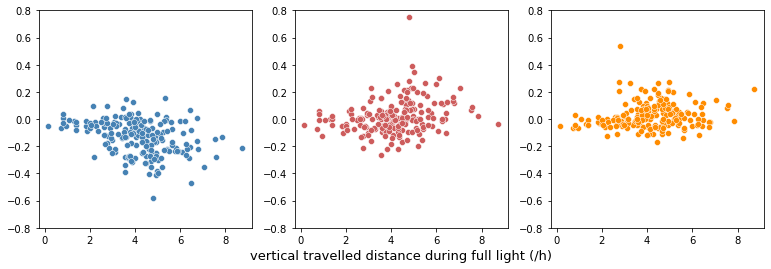

In [9]:
l=1
c=3
fig = plt.figure(figsize=(13,4)) #/100 si trop grand nbr
df_plt = df_BS.groupby(['HenID']).mean().reset_index()
plt.subplot(l,c,1)
#plt.figure(figsize=(5,4))
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_reactivity_index',
                color=pal_['food_reactivity_index'])#,  size="size", sizes=(20, 200))
plt.xlabel('')
plt.ylabel('')
#plt.title('food reactivity index')
plt.yticks(fontsize=10)
plt.ylim((-0.8, 0.8))

#plt.figure(figsize=(5,4))
plt.subplot(l,c,2)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_reactivity_index_forward',
                color=pal_['food_reactivity_index_forward'])#,  size="size", sizes=(20, 200))
plt.ylabel('')
#plt.title('hens\' mean value')
plt.xlabel('vertical travelled distance during full light (/h)', size=13)
plt.ylim((-0.8, 0.8))

#plt.figure(figsize=(5,4))
plt.subplot(l,c,3)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_reactivity_index_backward',
                color=pal_['food_reactivity_index_backward'])#,  size="size", sizes=(20, 200))
plt.ylabel('')
#plt.title('food reactivity index backward push')
plt.xlabel('')
plt.ylim((-0.8, 0.8))
plt.savefig(os.path.join(path_extracted_data,'dfBS_Raw_VTD_food.png'),dpi=300,format='png',bbox_inches='tight')
plt.show();

--------------------------------------------------------------------------


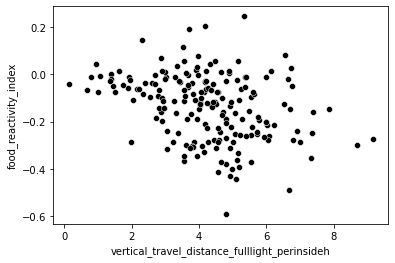

(-0.3356027714075489, 2.207417169117929e-06)
SpearmanrResult(correlation=-0.3483884230646424, pvalue=8.40540731956877e-07)
--------------------------------------------------------------------------


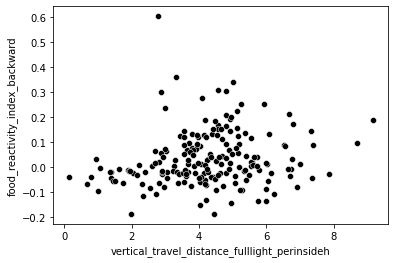

(0.168836620683951, 0.01987829251329487)
SpearmanrResult(correlation=0.2008835351905068, pvalue=0.005450923619752253)
--------------------------------------------------------------------------


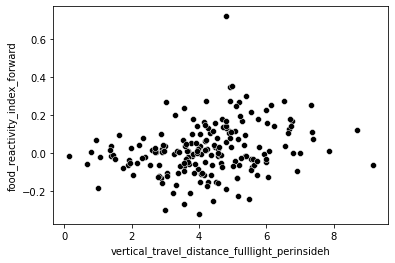

(0.24667019941376572, 0.00060170100659179)
SpearmanrResult(correlation=0.2715331085129928, pvalue=0.00015090554327324367)
--------------------------------------------------------------------------


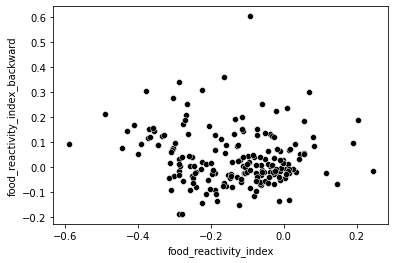

(-0.14284171114544655, 0.04929426508294948)
SpearmanrResult(correlation=-0.11998320408350721, pvalue=0.09916755916533503)
--------------------------------------------------------------------------


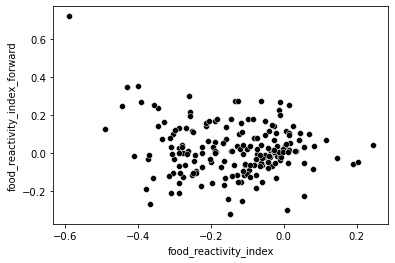

(-0.16177208365363865, 0.025756212533174488)
SpearmanrResult(correlation=-0.01263280364961269, pvalue=0.8626600734312564)
--------------------------------------------------------------------------


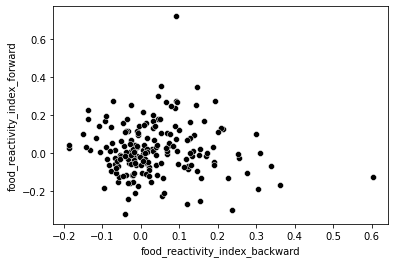

(-0.04582045571447818, 0.5301655054755768)
SpearmanrResult(correlation=0.016651576585442664, pvalue=0.8196249992772958)


In [79]:
li_mvt_test = ['vertical_travel_distance_fulllight_perinsideh','food_reactivity_index',
               'food_reactivity_index_backward','food_reactivity_index_forward']
#in case but we are not studying this
#sns.scatterplot(data=df_BS.groupby(['HenID','BS_type']).mean().reset_index(), x="vertical_travel_distance_fulllight_perinsideh", 
#                y="food_related_behavior_final", hue='BS_type')
for i in range(0,len(li_mvt_test)-1):
    for j in range(i+1,len(li_mvt_test)):
        print('--------------------------------------------------------------------------')
        df_plt = df_BS[df_BS['BS_type']=='time'].groupby(['HenID']).mean().reset_index()
        sns.scatterplot(data=df_plt,
                        x=li_mvt_test[i], y=li_mvt_test[j], color='black')#,  size="size", sizes=(20, 200))
        plt.show();
        print(pearsonr(df_plt[li_mvt_test[i]].tolist(), df_plt[li_mvt_test[j]].tolist()))
        print(spearmanr(df_plt[li_mvt_test[i]].tolist(), df_plt[li_mvt_test[j]].tolist()))

# Available data - In words

In [81]:
mi = min(df_BS['DOA'].tolist())
ma = max(df_BS['DOA'].tolist())
print('We are involving a period of %d days of tracking during the days from the DOA %d until DOA %d'%(ma-mi, mi, ma))

We are involving a period of 231 days of tracking during the days from the DOA 179 until DOA 410


In [82]:
df_info = df_BS.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()
df_info['nbrDaysTracked'] = df_info['DOA'].map(lambda x: len(set(x)))
df_info = df_info.sort_values(['nbrDaysTracked'])
display(df_info.head(3))
#pen 5 had issues with batteries of markers!
df_info['nbrDaysTracked'].mean()

C:\Users\camil\AppData\Local\Temp/ipykernel_27084/2926827144.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_info = df_BS.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()


,HenID,DOA,level,PenID,nbrDaysTracked
111,hen_219,"[319, 333, 338, 340, 347, 354, 361]","[2021-04-18 00:00:00, 2021-05-02 00:00:00, 202...","[pen10, pen10, pen10, pen10, pen10, pen10, pen10]",7
0,hen_1,"[179, 186, 193, 200, 207, 210, 214, 216, 228, ...","[2020-11-29 00:00:00, 2020-12-06 00:00:00, 202...","[pen9, pen9, pen9, pen9, pen9, pen9, pen9, pen...",10
133,hen_29,"[179, 186, 193, 200, 207, 210, 214, 216, 228, ...","[2020-11-29 00:00:00, 2020-12-06 00:00:00, 202...","[pen9, pen9, pen9, pen9, pen9, pen9, pen9, pen...",10


25.321052631578947

In [83]:
print('Hens had in average %d days tracked with a minimum of %d days tracked.'%(round(df_info['nbrDaysTracked'].mean(),0),
                                                                                df_info['nbrDaysTracked'].min()))

Hens had in average 25 days tracked with a minimum of 7 days tracked.


In [85]:
print('In other words, %d hens were used in subsequent analysis with a total of %d observations.'%(len(df_BS['HenID'].unique()),
                                                                                                   df_BS.shape[0]))

In other words, 190 hens were used in subsequent analysis with a total of 4811 observations.


# Available data - Visually

#heatmap of the hens, one row per hen: 1 means existing tracked day for the hen
df_plt = df_daily[['HenID', 'PenID', 'Treatment', 'CLASS','level','duration_5_Zone_min']].copy()
#dico_cl = {'EPI':'unknown', 'LEXP':'LEXP', 'MEXP':'MEXP', 'LEXPLOST':'unknown', 'MEXPLOST':'unknown','NewAfterEpi':'unknown', #'NewAfterEpiLOST':'unknown'}
#df_plt['CLASS'] = df_plt['CLASS'].map(lambda x: dico_cl[x])

#####find missing days
Daterange = pd.date_range(start = df_daily['level'].min(), end = df_daily['level'].max(), freq = 'D')    
li_missing_dates = [i for i in Daterange if i not in df_plt['level'].unique()]

#####add one row per missing dates for a random hen with duration_5_Zone_min beeing np.nan
x = df_plt.iloc[0]
df_missingdate = pd.DataFrame([{'level':d, 'duration_5_Zone_min':np.nan, 'HenID':x['HenID'], 'PenID':x['PenID'], 
                                'Treatment':x['Treatment'],'CLASS':x['CLASS']} for d in li_missing_dates])
print(df_plt.shape)
df_plt = df_plt.append(df_missingdate, ignore_index=True)
print(df_plt.shape)
df_plt['level'] = df_plt['level'].map(lambda x: dt.datetime.date(x))
df_plt.sort_values(['level'], inplace=True)
li_date = df_plt['level'].unique()

#####say if bird was tracked on taht day or not (i.e. we have his duration in zone 5)
df_plt['Tracked'] = df_plt['duration_5_Zone_min'].map(lambda x: int(not math.isnan(x)))
display(df_plt.head(3))
df_plt = df_plt.pivot(index=['HenID', 'PenID', 'Treatment', 'CLASS'], columns='level', values='Tracked').reset_index()
df_plt = df_plt.fillna(0)
df_plt.sort_values(['PenID'], inplace=True)
li_henorder = df_plt['HenID'].tolist()
print(df_plt.shape)
df_plt.head(3)

#per hens
fig = plt.figure(figsize=(15,30))
sns.heatmap(df_plt[li_date].to_numpy(), xticklabels=li_date,  yticklabels=df_plt['HenID'].tolist(), cmap="YlGnBu")
plt.title('Available data per treatment')
plt.savefig(os.path.join(path_extracted_data_chapter2,'DataPerHens.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

#per treatment
df_plt_summarized = df_plt.groupby(['Treatment','PenID'])[li_date].sum().reset_index()
df_plt_summarized['name'] = df_plt_summarized.apply(lambda x: x['Treatment']+' - Pen '+str(x['PenID']), axis=1)
fig = plt.figure(figsize=(20,3))
sns.heatmap(df_plt_summarized[li_date].to_numpy(), xticklabels=li_date, 
            yticklabels=df_plt_summarized['name'].tolist(), cmap="YlGnBu", annot=True)
plt.title('Available data per treatment')
plt.savefig(os.path.join(path_extracted_data_chapter2,'DataPerTreatment.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

#per class
df_plt_summarized = df_plt.groupby(['CLASS','Treatment','PenID'])[li_date].sum().reset_index()
df_plt_summarized['name'] = df_plt_summarized.apply(lambda x: x['CLASS']+' - '+x['Treatment']+' - Pen '+str(x['PenID']), 
                                                    axis=1)
fig = plt.figure(figsize=(20,8))
sns.heatmap(df_plt_summarized[li_date].to_numpy(), xticklabels=li_date, 
            yticklabels=df_plt_summarized['name'].tolist(), cmap="YlGnBu", annot=True)
plt.title('Available data per class')
plt.savefig(os.path.join(path_extracted_data_chapter2,'DataPerClass.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()